## ABOUT:
- This notebook was one of my first exposures to NLP, being rather inexperienced
- in this notebook we:
    1. Explore textual features, make visualizations
    2. Extract textual features that are indicative of Disaster (based on the plots)
    3. Fine tune catboost and randomforest models
    4. Predict the test set

In [2]:
# import libraries
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from nltk.stem import *
from nltk.tokenize import word_tokenize 
from collections import Counter 
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold,cross_val_score
from sklearn.model_selection import train_test_split
from numpy import mean
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
import string
import re
import numpy as np
from textblob import TextBlob
import plotly.figure_factory as ff
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from IPython.display import Image
from random import choices
from sklearn.preprocessing import OneHotEncoder
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from string import digits
from category_encoders.target_encoder import TargetEncoder
from category_encoders.leave_one_out import LeaveOneOutEncoder
from sklearn.model_selection import GridSearchCV

In [2]:
# read data
train_data=pd.read_csv("train.csv")
test_data=pd.read_csv("test.csv")

In [3]:
print("Training Data has {} rows and {} columns.".format(train_data.shape[0],train_data.shape[1]))
print("Test Data has {} rows and {} columns.".format(test_data.shape[0],test_data.shape[1]))

Training Data has 7613 rows and 5 columns.
Test Data has 3263 rows and 4 columns.


In [4]:
# merge training and test data for preprocessing convenience
disaster_data=pd.concat([train_data,test_data],axis=0,sort=True).reset_index()
disaster_data.drop(['index'],axis=1,inplace=True)

#### check duplicates

In [5]:
print("Number of rows: ",len(disaster_data))
print("Number of unique id:", len(disaster_data['id'].unique()))

Number of rows:  10876
Number of unique id: 10876


In [6]:
disaster_data[disaster_data.duplicated()]

,id,keyword,location,target,text


#### check NAs

In [7]:
print("percentage of NAs: ")
print(round((disaster_data.isna().sum()/len(disaster_data))*100,3))

percentage of NAs: 
id           0.000
keyword      0.800
location    33.450
target      30.002
text         0.000
dtype: float64


- Observation:
    - significant chunk of rows from location column are **missing**
    - they may hold useful infomation so i will treat them as a **separate category**

In [8]:
# fill NAs as 'unknown' category
disaster_data.loc[:,['keyword','location']]=disaster_data.loc[:,['keyword','location']].fillna('unknown')

# EDA

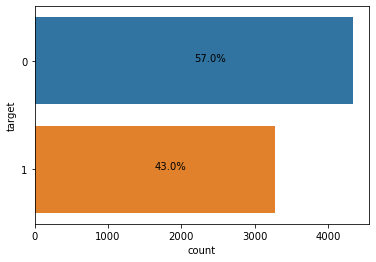

In [9]:
# countplot of response variable
axes = sb.countplot(y = train_data['target'])
total = len(train_data['target'])
for p in axes.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = (p.get_x() + p.get_width()) / 2
        y = p.get_y() + p.get_height()/2
        axes.annotate(percentage, (x, y))

- Observation:
    - there are slightly less real disaster samples

In [10]:
print("Number of levels:")
print()
for var in disaster_data.columns:
    print("{:<20}:{}".format(var,len(disaster_data[var].unique())))

Number of levels:

id                  :10876
keyword             :222
location            :4522
target              :3
text                :10678


- Observation:
    - there are a lot of levels on keyword and location columns
    - likely need to reduce the number of levels by grouping them somehow

## id variable

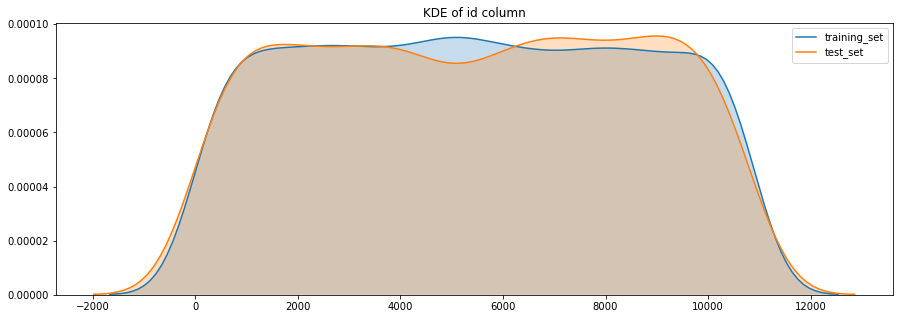

In [11]:
# KDE of id column
f, axes = plt.subplots(1,1 , figsize=(15, 5))
train_test_dict={'training_set':train_data,
                 'test_set':test_data}
for name,data in train_test_dict.items():
    sb.kdeplot(data['id'],shade=True,label=name).set(title='KDE of id column')

- inference:
    - id distribution is quite similar for training and test set, this suggests the training and test sets are split by random via id

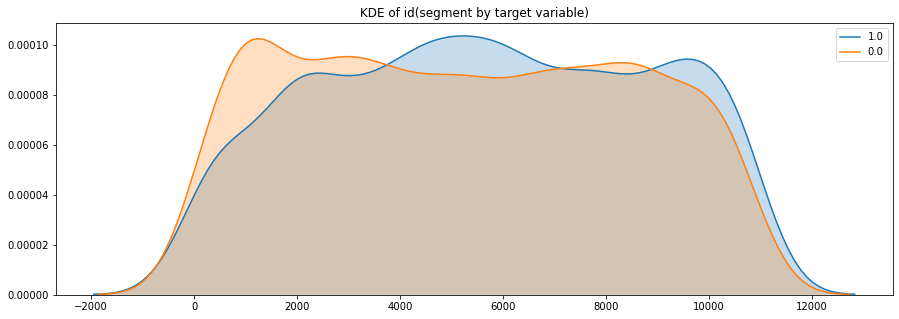

In [12]:
f, axes = plt.subplots(1,1 , figsize=(15, 5))
for level in disaster_data['target'].unique():
    sb.kdeplot(disaster_data[disaster_data['target']==level]['id'],shade=True,label=level).set(title='KDE of id(segment by target variable)')

- Observation:
    - id's below 4000 are more likely to be fake(larger orange area). above 4000 is more likely to be fake(larger blue area)
- inference:
    - there are 2 possible causes:
        1. more fake tweets were placed on the first 4000 id for some reason.
            - this would make id a good predictor
        
        2. by chance, the random split of training and test set caused this. 
            - this would cause models to perform better in training set and performance on test set will suffer
- the only way to find out will be to make predictions using only the id column on the unseen test set

In [13]:
# initiate model
decTree=DecisionTreeClassifier()

# extracting the training and test data
X_train=train_data.loc[:,['id']]
y_train=train_data.loc[:,'target']
X_test=test_data.loc[:,['id']]

# train model and make predictions with only 'id' column
decTree.fit(X_train,y_train)
y_pred=decTree.predict(X_test)

# compiling results
id_only_results=pd.concat([test_data[['id']],pd.Series(y_pred,name='target')],axis=1)

# export to csv
id_only_results.to_csv('id_only_results.csv',index=False)

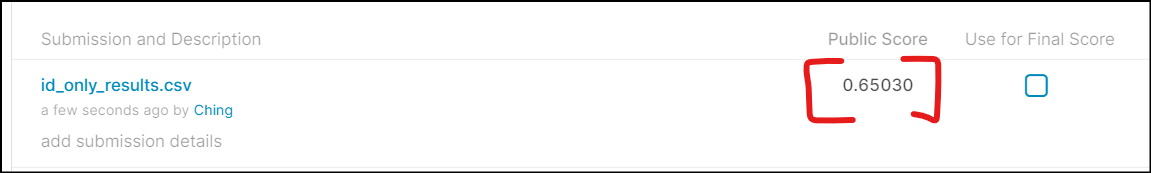

In [3]:
Image('id_only_results.PNG')

- Inference:
    - very suprisingly, **using ONLY the id column gave predictions that were way better than random chance**
    - my guess is that because the rows are grouped by their respective keywords and keywords have some predictive power,
        that gave the id column some correlation to the target variable
        - in this case it would be okay to use id variable. however, once the order of rows are reset, this variable will be very missleading

## keyword variable

In [14]:
disaster_data.keyword.unique()

array(['unknown', 'ablaze', 'accident', 'aftershock',
       'airplane%20accident', 'ambulance', 'annihilated', 'annihilation',
       'apocalypse', 'armageddon', 'army', 'arson', 'arsonist', 'attack',
       'attacked', 'avalanche', 'battle', 'bioterror', 'bioterrorism',
       'blaze', 'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard',
       'blood', 'bloody', 'blown%20up', 'body%20bag', 'body%20bagging',
       'body%20bags', 'bomb', 'bombed', 'bombing', 'bridge%20collapse',
       'buildings%20burning', 'buildings%20on%20fire', 'burned',
       'burning', 'burning%20buildings', 'bush%20fires', 'casualties',
       'casualty', 'catastrophe', 'catastrophic', 'chemical%20emergency',
       'cliff%20fall', 'collapse', 'collapsed', 'collide', 'collided',
       'collision', 'crash', 'crashed', 'crush', 'crushed', 'curfew',
       'cyclone', 'damage', 'danger', 'dead', 'death', 'deaths', 'debris',
       'deluge', 'deluged', 'demolish', 'demolished', 'demolition',
       'derail'

- Observation:
    - clearly, there are many levels that **can be grouped together** 
    - also, there are certain levels with a **%20 in the middle**
        - which could be a possible new feature

### engineered feature: %20

In [15]:
# extract presence of %20
disaster_data['%20']=disaster_data.keyword.apply(lambda x: 'present' if '%20' in x else 'absent')

[Text(0.5, 1.0, 'countplot of %20')]

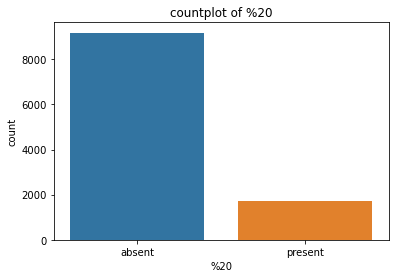

In [16]:
sb.countplot(x=disaster_data['%20']).set(title='countplot of %20')

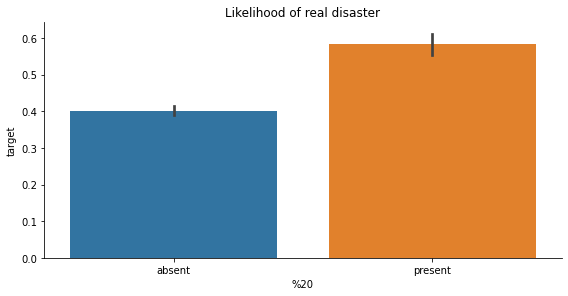

In [17]:
sb.catplot(x='%20',y='target',data=disaster_data,kind='bar',height=4, aspect=2).set(title='Likelihood of real disaster')

- Observation:
    - '%20' is present in a only small proportion of the dataset
    - however, tweets with '%20' is **more likely to be real**

### reducing cardinality of keyword variable

In [18]:
# apply lemmatization
lemmatizer = WordNetLemmatizer() 
lemmatized_keywords=disaster_data.keyword.apply(lambda x: lemmatizer.lemmatize(x.split('%20')[0])).unique()
print("Number of levels from lemmatization: \n", len(lemmatized_keywords))
print("Some words from lemmzatization: \n",lemmatized_keywords[:10])

Number of levels from lemmatization: 
 202
Some words from lemmzatization: 
 ['unknown' 'ablaze' 'accident' 'aftershock' 'airplane' 'ambulance'
 'annihilated' 'annihilation' 'apocalypse' 'armageddon']


In [19]:
# apply porter stemming(older stemming version)
ps = PorterStemmer() 
porter_stemmed_keywords=disaster_data.keyword.apply(lambda x: ps.stem(x.split('%20')[0])).unique()
print("Number of levels from stemming: \n", len(porter_stemmed_keywords))
print("Some words from stemming: \n",porter_stemmed_keywords[:10])

Number of levels from stemming: 
 160
Some words from stemming: 
 ['unknown' 'ablaz' 'accid' 'aftershock' 'airplan' 'ambul' 'annihil'
 'apocalyps' 'armageddon' 'armi']


In [20]:
# apply snowball stemming(more universally accepted than porter stem)
ss=SnowballStemmer("english")
snowball_stemmed_keywords=disaster_data.keyword.apply(lambda x: ss.stem(x.split('%20')[0])).unique()
print("Number of levels from stemming: \n", len(snowball_stemmed_keywords))
print("Some words from stemming: \n",snowball_stemmed_keywords[:10])

Number of levels from stemming: 
 160
Some words from stemming: 
 ['unknown' 'ablaz' 'accid' 'aftershock' 'airplan' 'ambul' 'annihil'
 'apocalyps' 'armageddon' 'armi']


- Obseravtion:
    - stemming is able to group the keywords down to a smaller number of levels, though the stemmed words look much wierder
   

### engineered features: stemmed_keywords, lemmatized_keywords

In [21]:
# try both lemmatization and stemming
disaster_data['stemmed_keywords']=disaster_data.keyword.apply(lambda x: ss.stem(x.split('%20')[0]))
disaster_data['lemmatized_keywords']=disaster_data.keyword.apply(lambda x: lemmatizer.lemmatize(x.split('%20')[0]))
# rename orignal keyword column
disaster_data.rename(columns={'keyword':'original_keywords'},inplace=True)

#### performance of keyword variable with one hot encoding

In [22]:
# testing performace of enginnered features
stemmed_keyword_df=disaster_data[~disaster_data['target'].isna()][['stemmed_keywords']]
lemmatized_keyword_df=disaster_data[~disaster_data['target'].isna()][['lemmatized_keywords']]
original_keyword_df=disaster_data[~disaster_data['target'].isna()][['original_keywords']]
target_column=train_data.target

# one hot encode
enc = OneHotEncoder()
stemmed_keyword_df=pd.DataFrame(enc.fit_transform(stemmed_keyword_df).toarray())
lemmatized_keyword_df=pd.DataFrame(enc.fit_transform(lemmatized_keyword_df).toarray())
original_keyword_df=pd.DataFrame(enc.fit_transform(original_keyword_df).toarray())

# convert all columns to category
for df in [stemmed_keyword_df,lemmatized_keyword_df,original_keyword_df]:
    df.astype('category')


# train models with cross validation
skf = StratifiedKFold(n_splits=4, random_state=1)
rfc=RandomForestClassifier(n_estimators=300,random_state=0)
cbc=CatBoostClassifier(iterations=100,
                       random_state=0)
model_names={'Random Forest Classifier':rfc
             ,'Catboost Classifier':cbc}
keywords_type={'Lemmatized':lemmatized_keyword_df,
               'Stemmed':stemmed_keyword_df,
              'Original':original_keyword_df}
for name,model in model_names.items():
    print(name)
    for Type,keywords_df in keywords_type.items():
        accuracy_list = cross_val_score(model, keywords_df, target_column, scoring='accuracy', cv=skf, n_jobs=-1)
        print('{} Validation accuracy: {:.2f}'.format(Type,mean(accuracy_list)))

Random Forest Classifier
Lemmatized Validation accuracy: 0.51
Stemmed Validation accuracy: 0.51
Original Validation accuracy: 0.51
Catboost Classifier
Lemmatized Validation accuracy: 0.51
Stemmed Validation accuracy: 0.50
Original Validation accuracy: 0.51


- inference:
    - looks like variable keyword gives a performance equal to random chance, 50/50
    - lemmatizing or stemming doesn't seem to improve on the original column either
    - i suspect it's due to the **curse of dimentiality**
        - one hot encoding resulted in too many columns which tree-based models perform quite poorly

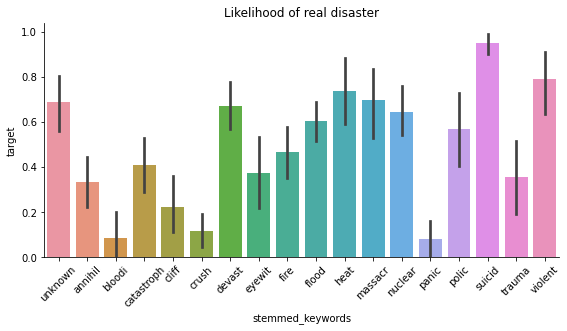

In [23]:
# visualizing some of the stemmed keywords
random_20_keywords=choices(disaster_data.stemmed_keywords.unique(),k=20)
random_20_keywords_df=disaster_data.iloc[[index for index,keyword in enumerate(disaster_data.stemmed_keywords) if keyword in random_20_keywords],:]

sb.catplot(x='stemmed_keywords',y='target',data=random_20_keywords_df,kind='bar',height=4, aspect=2).set(title='Likelihood of real disaster').set_xticklabels(rotation=45)

- Inference:
    - even though the variable itelf does not give a good accuracy score, it is **no doubt a good predictor by looking at the plot**
    - certain categories give a very good separation of target variable classes

#### performance of keyword variable with mean encoding

In [24]:
# testing performace of enginnered features
stemmed_keyword_df=disaster_data[~disaster_data['target'].isna()][['stemmed_keywords','target']]
lemmatized_keyword_df=disaster_data[~disaster_data['target'].isna()][['lemmatized_keywords','target']]
original_keyword_df=disaster_data[~disaster_data['target'].isna()][['original_keywords','target']]
target_column=train_data.target

# mean encoding
mean_encoding=stemmed_keyword_df.groupby('stemmed_keywords')['target'].agg(['mean'])['mean']
stemmed_keyword_df=pd.DataFrame(stemmed_keyword_df.stemmed_keywords.map(mean_encoding))
mean_encoding=lemmatized_keyword_df.groupby('lemmatized_keywords')['target'].agg(['mean'])['mean']
lemmatized_keyword_df=pd.DataFrame(lemmatized_keyword_df.lemmatized_keywords.map(mean_encoding))
mean_encoding=original_keyword_df.groupby('original_keywords')['target'].agg(['mean'])['mean']
original_keyword_df=pd.DataFrame(original_keyword_df.original_keywords.map(mean_encoding))

# train models with cross validation
skf = StratifiedKFold(n_splits=4, random_state=1)
rfc=RandomForestClassifier(n_estimators=300,random_state=0)
cbc=CatBoostClassifier(iterations=100,
                       random_state=0)
model_names={'Random Forest Classifier':rfc
             ,'Catboost Classifier':cbc}
keywords_type={'Lemmatized':lemmatized_keyword_df,
               'Stemmed':stemmed_keyword_df,
              'Original':original_keyword_df}
for name,model in model_names.items():
    print(name)
    for Type,keywords_df in keywords_type.items():
        accuracy_list = cross_val_score(model, keywords_df, target_column, scoring='accuracy', cv=skf, n_jobs=-1)
        print('{} Validation accuracy: {:.2f}'.format(Type,mean(accuracy_list)))

Random Forest Classifier
Lemmatized Validation accuracy: 0.68
Stemmed Validation accuracy: 0.66
Original Validation accuracy: 0.69
Catboost Classifier
Lemmatized Validation accuracy: 0.69
Stemmed Validation accuracy: 0.67
Original Validation accuracy: 0.69


- Observation:
    - clearly, the **appropriate encoding is necessary to capture the information in the variable**
    - mean encoding performed much better than one hot encoder (ps: one hot encoding performed better than label encoding)
        - however, there still needs to be some regularization so that we do not overfit due to this encoding
    - **lemmatizing does not seem to give any improvement in performance**
    - **stemming actually caused reduced performance** likely because words that should be kept separate are merged together

### engineered feature: keyword_frequency_encoded

In [25]:
# most frequent keywords
keyword_frequency=Counter(disaster_data['stemmed_keywords'])
keyword_frequency.most_common(10)

[('bodi', 150),
 ('burn', 150),
 ('derail', 150),
 ('drown', 150),
 ('emerg', 150),
 ('evacu', 150),
 ('fatal', 150),
 ('flood', 150),
 ('hijack', 150),
 ('obliter', 150)]

In [26]:
# least frequent keywords
keyword_frequency.most_common()[-10:]

[('wreckag', 50),
 ('collis', 49),
 ('chemic', 45),
 ('volcano', 42),
 ('bush', 38),
 ('war', 35),
 ('battl', 33),
 ('threat', 16),
 ('radiat', 14),
 ('epicentr', 13)]

In [27]:
# encode keywords by frequency
disaster_data['keyword_frequency_encoded']=disaster_data.stemmed_keywords.map(keyword_frequency)

In [28]:
# encode keywords by mean
keyword_mean=dict(disaster_data.groupby('stemmed_keywords').agg(['mean'])['target'])
disaster_data['keyword_mean_encoded']=disaster_data.stemmed_keywords.map(keyword_mean['mean'])

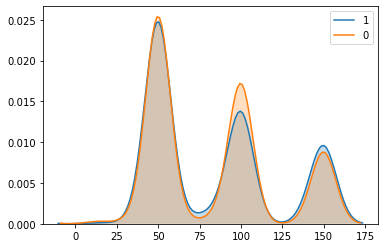

In [29]:
for level in train_data.target.unique():
    sb.kdeplot(data=disaster_data[disaster_data.target==level]['keyword_frequency_encoded'],label=level,shade=True)

- Observation:
    - clearly **frequency of keywords will not be a good predictor** because the data was highly manipulated beforehand to have a specific number of tweets for each topic/keyword

## location variable

In [30]:
# first 100 locations
disaster_data.location.unique()[:100]

array(['unknown', 'Birmingham', 'Est. September 2012 - Bristol', 'AFRICA',
       'Philadelphia, PA', 'London, UK', 'Pretoria', 'World Wide!!',
       'Paranaque City', 'Live On Webcam', 'milky way',
       'GREENSBORO,NORTH CAROLINA', 'England.',
       'Sheffield Township, Ohio', 'India', 'Barbados', 'Anaheim',
       'Abuja', 'USA', 'South Africa', 'Sao Paulo, Brazil',
       'hollywoodland ', 'Edmonton, Alberta - Treaty 6',
       'Inang Pamantasan', 'Twitter Lockout in progress', 'Concord, CA',
       'Calgary, AB', 'San Francisco', 'CLVLND', 'Nashville, TN',
       'Santa Clara, CA', 'UK', 'St. Louis, MO', 'Walker County, Alabama',
       'Australia', 'North Carolina', 'Norf Carolina',
       'San Mateo County, CA', 'Njoro, Kenya', "Your Sister's Bedroom",
       'Arlington, TX', 'South Bloomfield, OH', 'New Hanover County, NC',
       'Maldives', 'Manchester, NH', 'Wilmington, NC', 'global',
       'Alberta | Sask. | Montana', 'Charlotte', 'Baton Rouge, LA',
       'Hagerstown, 

- Observation:
    - location variable has way **too much variance**.
    - some locations are not even locations themselves
    
- nonetheless, since **30% of locations are unkwown**, lets see if that could be a good predictor

### engineered feature: unknown location

In [31]:
disaster_data['unknown_location']=disaster_data.location.apply(lambda x: x if x=='unknown' else 'known' )

[Text(0.5, 1.0, 'countplot of unknown_location')]

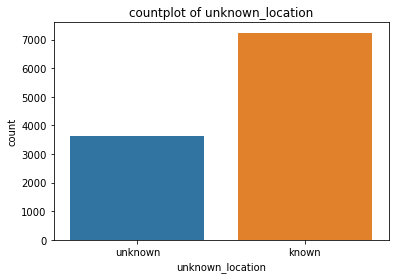

In [32]:
sb.countplot(x=disaster_data['unknown_location']).set(title='countplot of unknown_location')

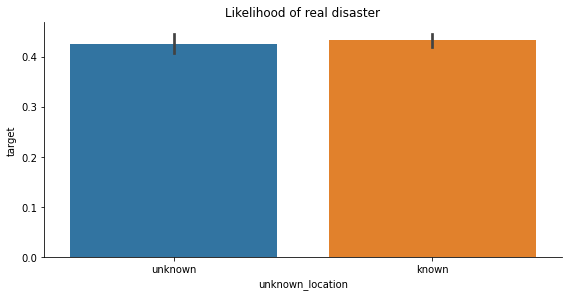

In [33]:
sb.catplot(x='unknown_location',y='target',data=disaster_data,kind='bar',height=4, aspect=2).set(title='Likelihood of real disaster')

- Observation:
    - clearly, it doesn't matter if the location is unknown or not
- since there are so many levels and over 30% of values are missing i will drop this feature and focus on more important features   

In [34]:
# drop
disaster_data.drop(['location','unknown_location'],axis=1,inplace=True)

# text variable feature engineering
- first i will extract some features, otherwise these information will be lost after text preprocessing

### engineered feature: sentiment_polarity (before preprocessing)

In [35]:
disaster_data['sentiment_before_preprocessing']=disaster_data.text.apply(lambda x: TextBlob(x).sentiment.polarity)

### engineered feature: number of words

In [36]:
disaster_data['number_of_words']=disaster_data.text.apply(lambda x: len(x.split()))

### engineered feature: number of stopwords

In [37]:
stopwords_list=stopwords.words('english')
disaster_data['number_of_stopwords']=disaster_data['text'].apply(lambda x: len([word for word in x.lower().split() if word in stopwords_list]))

### engineered feature: proportion of stopwords

In [38]:
disaster_data['proportion_of_stopwords']=disaster_data['number_of_stopwords']/disaster_data['number_of_words']

### engineered feature: text length

In [39]:
disaster_data['text_length']=disaster_data.text.apply(len)

### engineered feature: number of punctuations

In [40]:
# extract all punctuations
punctuations=string.punctuation
disaster_data['all_punctuations']=disaster_data['text'].apply(lambda text:[char  for char in text if char in punctuations])
# extract number of punctuations
disaster_data['number_of_punctuations']=disaster_data['all_punctuations'].apply(lambda x: len(x))

### engineered feature: proportion of punctuations

In [41]:
disaster_data['proportion_of_punctuations']=disaster_data['number_of_punctuations']/disaster_data['text_length']

### engineered feature: number of each and every punctuation
- e.g. number_of_# ,number_of_@ etc.

In [42]:
for target_punctuation in punctuations:
    disaster_data['number_of_'+target_punctuation]=disaster_data['all_punctuations'].apply(lambda x: len([char for char in x if char==target_punctuation]))

### engineered feature: number of numerics

In [43]:
disaster_data['number_of_numerics']=disaster_data['text'].apply(lambda text:sum([1  for char in text if char.isdigit()]))

### engineered feature: presence of links

In [44]:
# extract presence of links
disaster_data['presence_of_links']=disaster_data.text.apply(lambda x: 1 if 'http' in x else 0)

### engineered feature: number of uppercases words

In [45]:
disaster_data['number_of_uppercase_words']=disaster_data.text.apply(lambda x: sum([1 for word in x.split() if word.isupper()]))

### engineered feature: proportion of uppercase words

In [46]:
disaster_data['proportion_of_uppercase_words']=disaster_data['number_of_uppercase_words']/disaster_data['number_of_words']

### engineered features: presence_of_emojis
- emojis could indicate a casual tweet so they might be less liekly to be real disasters

In [47]:
def emoji_present(target):
    if ((":)" in target) or (":-)" in target) or (":(" in target) or 
        (":-(" in target) or (":p" in target) or (":D" in target) or (":-D" in target)):
        return 1 
    else:
        return 0

In [48]:
disaster_data['presence_of_emojis']=disaster_data.text.apply(lambda x: emoji_present(x))

In [49]:
disaster_data['presence_of_emojis'].value_counts()

0    10814
1       62
Name: presence_of_emojis, dtype: int64

- Observation:
    - even if this is a good predictor, the amount of information gain is only very small because its only a small proportion

## text variable PREPROCESSING

In [50]:
# an example of link removal
print(re.sub(r"http\S+", "", """Sydney, Australia",Today marks the 70th anniversary of the bombing of Hiroshima a city I http://t.co/AcC1z5Q9Zw visited and was humbled by in November 2013 """))

Sydney, Australia",Today marks the 70th anniversary of the bombing of Hiroshima a city I  visited and was humbled by in November 2013 


In [51]:
# remove links (preprocessing)
disaster_data.text=disaster_data.text.apply(lambda x: re.sub(r"http\S+","",x))

In [52]:
# remove punctuations
disaster_data.text=disaster_data.text.apply(lambda x: x.translate(str.maketrans('', '', punctuations)))

In [53]:
# convert text to lower case
disaster_data.text=disaster_data.text.apply(lambda x: x.lower())

In [54]:
# remove stopwords
disaster_data.text=disaster_data.text.apply(lambda x: " ".join(word for word in x.split() if word not in stopwords_list))

In [55]:
# remove numerics
remove_digits = str.maketrans('', '', digits) 
disaster_data.text=disaster_data.text.apply(lambda x: x.translate(remove_digits))

### engineered feature: sentiment after preprocessing

In [56]:
disaster_data['sentiment_after_preprocessing']=disaster_data.text.apply(lambda x: TextBlob(x).sentiment.polarity)

# EDA of engineered variables

In [57]:
# first break into the engineered variables categorical and numeric types
cat_engineered_var=['presence_of_links','presence_of_emojis']
num_engineered_var=[]
remaining_var=['id', 'original_keywords', 'target', 'text', '%20', 'stemmed_keywords',
       'lemmatized_keywords', 'keyword_frequency_encoded',
       'keyword_mean_encoded','all_punctuations']
for col in disaster_data.columns:
    if (col not in cat_engineered_var) and (col not in remaining_var):
        num_engineered_var.append(col)

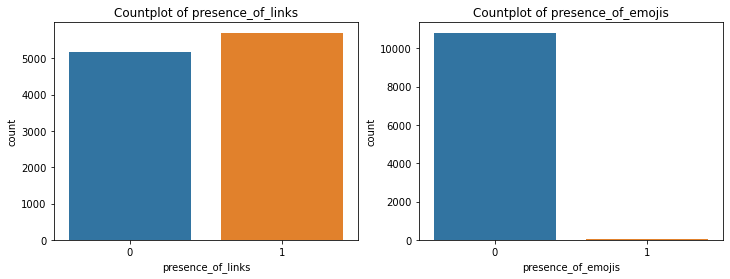

In [58]:
f, axes = plt.subplots(1, 2, figsize=(12, 4))
for i,var in enumerate(cat_engineered_var):
    sb.countplot(data=disaster_data, x=var,ax=axes[i]).set(title="Countplot of "+var)


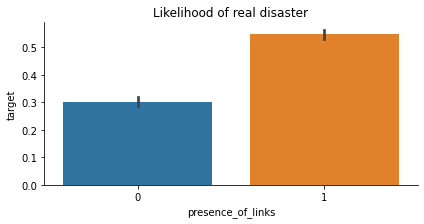

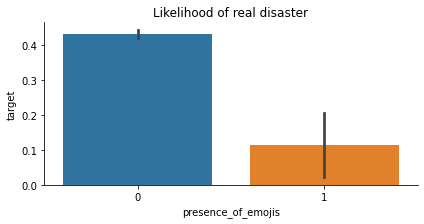

In [59]:
for var in cat_engineered_var:
    sb.catplot(x=var,y='target',data=disaster_data,kind='bar',height=3, aspect=2).set(title='Likelihood of real disaster')

- Observation:
    - clearly,both a  **strong predictors** because their presence create a separate in likelihood of real disaster
    - however, presence_of_emojis has very little information gain because the classes are highly imbalanced

C:\Users\tanch\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\tanch\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
C:\Users\tanch\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\tanch\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
C:\Users\tanch\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\tanch\Anaconda3\lib\site-packages\statsmodels\no

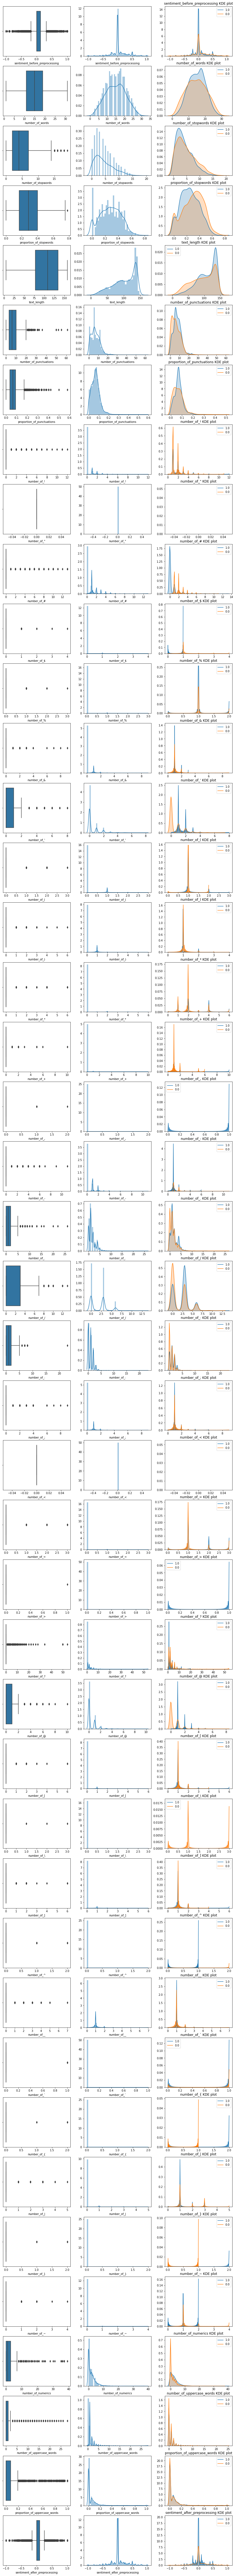

In [60]:
f, axes = plt.subplots(len(num_engineered_var), 3, figsize=(15, 4*len(num_engineered_var)))
for i,var in enumerate(num_engineered_var):
    sb.boxplot(disaster_data[var],ax=axes[i,0])
    sb.distplot(disaster_data[var],ax=axes[i,1])
    for level in disaster_data.target.unique():  
        sb.kdeplot(data=disaster_data[disaster_data.target==level][var],ax=axes[i,2],shade=True, label=level).set(title=var+" KDE plot")

- Observation:
    - there are some variables that are good predictors while some or not
        - i will remvoe variables that are mostly zeros or if their target variable KDE are too similar
        
    - good predictors are variables like proportion of stopwords:
        - **when proportion of stopwords is below 0.4, tweets are more likely to be real disasters(larger blue area)**
        
    - sentiment after preprocessing looks to be a better predictor then before preprocessing , but still quite poor
    

In [61]:
# keep these variables that look predictive enough
to_keep=["sentiment_after_preprocessing",'number_of_words', 'number_of_stopwords', 'proportion_of_stopwords', 'text_length',
         'number_of_punctuations', 'proportion_of_punctuations',"number_of_#","number_of_'",
         "number_of_@","number_of_{","number_of_}","number_of_/","number_of_numerics"]
# drop variables deemed non-predictive
for var in to_keep:
    if var not in to_keep:
        disaster_data.drop([var],axis=1,inplace=True)

### engineered features: proportion of punctuations(#,@ etc.) and proportion of numerics
- looking at **proportion** of stopwords feature, it seems to be a **better predictor than number** of stopwords. let's see if finding proportion helps for other features

In [62]:
# divide these by total number of punctuations to get their proportion
more_features=[]
for var in ["number_of_#","number_of_'","number_of_@","number_of_/","number_of_{","number_of_}"]:
    target_punctuation=var[-1]
    disaster_data["proportion_of_"+target_punctuation]=disaster_data[var]/disaster_data["number_of_punctuations"]
    more_features.append("proportion_of_"+target_punctuation)
    
# divide number of numeric by total length
disaster_data['proportion_of_numerics']=disaster_data['number_of_numerics']/disaster_data['text_length']
more_features.append("proportion_of_numerics")
# fill NAs with zero(due to division by zero)
disaster_data[more_features]=disaster_data[more_features].fillna(0)

### engineered feature: average_word_length

In [63]:
def avg_len(target):
    words_list=target.split()
    number_of_words=len(words_list)
    if number_of_words==0:
        return 0
    else: 
        sum_of_word_lengths=sum([len(word) for word in words_list])
        return sum_of_word_lengths/number_of_words

In [64]:
disaster_data['average_word_length']=disaster_data.text.apply(lambda x: avg_len(x))
more_features.append("average_word_length")

### EDA of engineered features

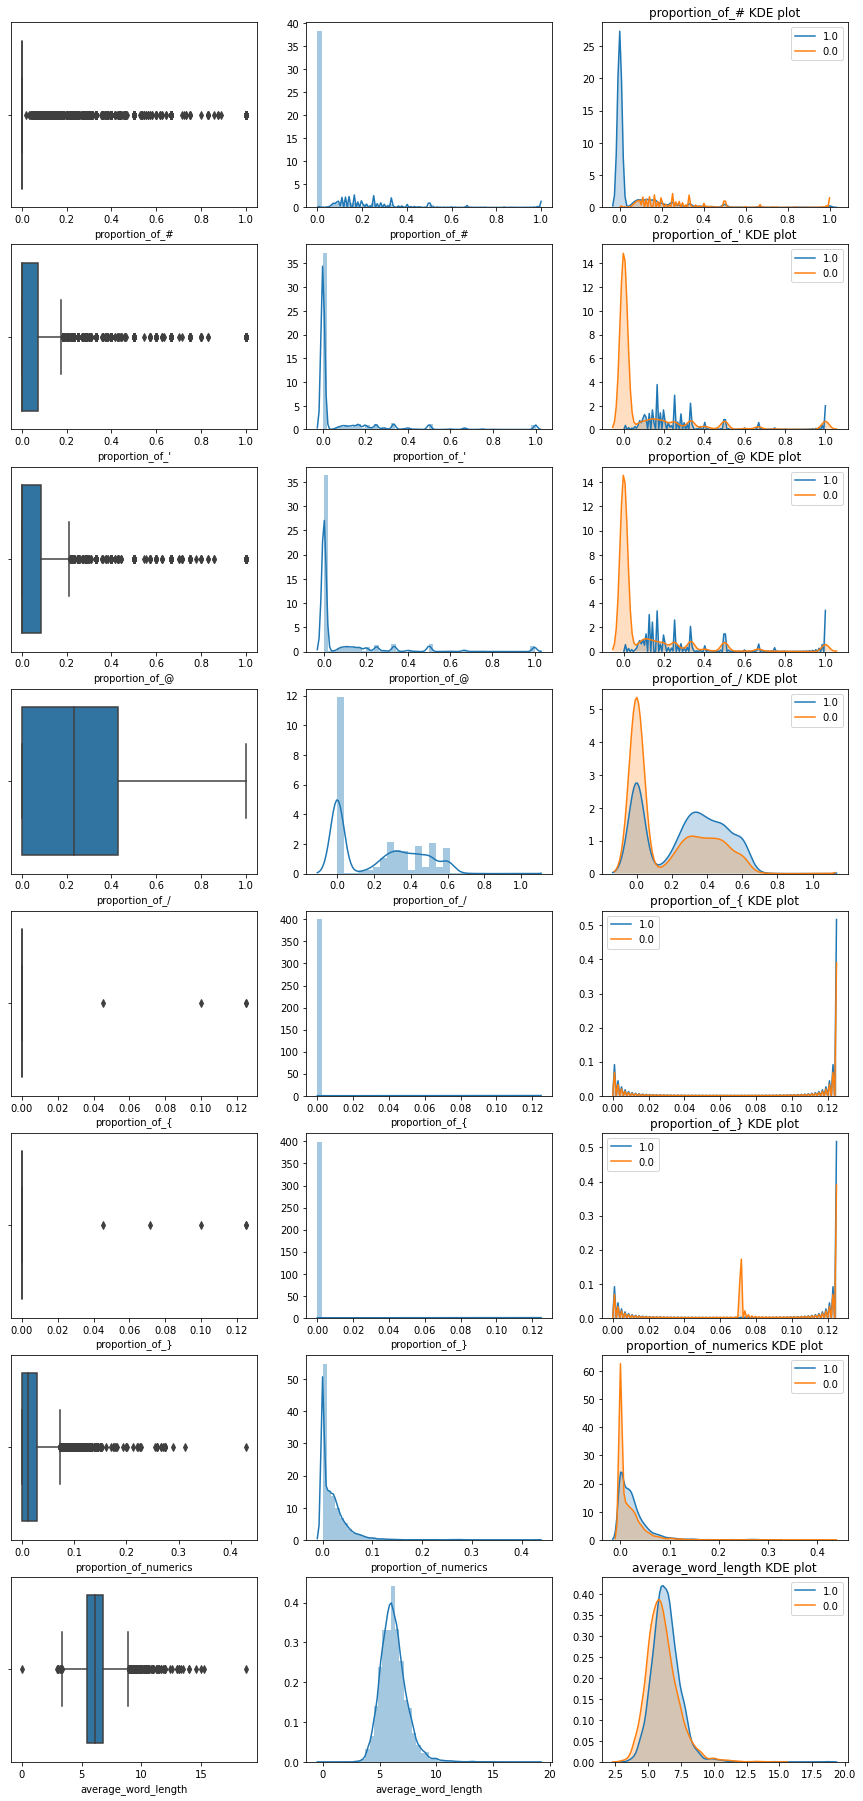

In [65]:
f, axes = plt.subplots(len(more_features), 3, figsize=(15, 4*len(more_features)))
for i,var in enumerate(more_features):
    sb.boxplot(disaster_data[var],ax=axes[i,0])
    sb.distplot(disaster_data[var],ax=axes[i,1])
    for level in disaster_data.target.unique():  
        sb.kdeplot(data=disaster_data[disaster_data.target==level][var],ax=axes[i,2],shade=True, label=level).set(title=var+" KDE plot")

- Observation:
    - of the feature aboves, proportion of { and } are poor predictors
    

In [66]:
# update engineered features to keep
to_keep.extend(['proportion_of_#',"proportion_of_'",'proportion_of_@',
                'proportion_of_/','proportion_of_numerics',"average_word_length"])
# update categoric features
cat_engineered_var.append('%20')

### adjust dtypes and preprocessing

In [67]:
# convert to categoric data type
disaster_data[['target']+cat_engineered_var]=disaster_data[['target']+cat_engineered_var].astype('category')

In [68]:
# encode %20 variable
disaster_data['%20']=disaster_data['%20'].cat.rename_categories({'absent':0,
                                                                 'present':1})


### testing performance of the engineered variables

In [69]:
engineered_variables=cat_engineered_var+to_keep
engineered_variables_df=pd.concat([disaster_data[engineered_variables],disaster_data.target],axis=1).copy()
engineered_variables_df=engineered_variables_df[~disaster_data.target.isna()]

In [70]:
# convert categorical variables to category 
engineered_variables_df[cat_engineered_var]=engineered_variables_df[cat_engineered_var].astype("category")
# convert response to categoric
engineered_variables_df.target=pd.Categorical(engineered_variables_df.target)

In [71]:
#separate predcitors from response
X=engineered_variables_df.iloc[:,:-1]
y=engineered_variables_df.target

# cross validation
skf = StratifiedKFold(n_splits=4, random_state=1)

# initiate models
rfc=RandomForestClassifier(n_estimators=300,random_state=0)
cbc=CatBoostClassifier(iterations=100,
                       cat_features=cat_engineered_var,
                       random_state=0)

model_names={'Random Forest Classifier':rfc
             ,'Catboost Classifier':cbc}

# train models with cross validation
for name,model in model_names.items():
    accuracy_list = cross_val_score(model, X,y, scoring='accuracy', cv=skf, n_jobs=-1)
    print('{} Validation accuracy: {:.2f}'.format(name,mean(accuracy_list)))

Random Forest Classifier Validation accuracy: 0.67
Catboost Classifier Validation accuracy: 0.68


In [72]:
# let's look at feature importances
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42,stratify=y)
for name,model in model_names.items():
    model.fit(X_train,y_train)
    y_pred=model.predict(X_test)
    print('{} Test accuracy: {:.2f}'.format(name,accuracy_score(y_test,y_pred)))

Random Forest Classifier Test accuracy: 0.71
Learning rate set to 0.170634
0:	learn: 0.6660186	total: 80.8ms	remaining: 8s
1:	learn: 0.6476223	total: 94.9ms	remaining: 4.65s
2:	learn: 0.6371296	total: 110ms	remaining: 3.56s
3:	learn: 0.6236331	total: 124ms	remaining: 2.98s
4:	learn: 0.6156621	total: 133ms	remaining: 2.54s
5:	learn: 0.6100709	total: 143ms	remaining: 2.25s
6:	learn: 0.6047896	total: 151ms	remaining: 2s
7:	learn: 0.6007390	total: 159ms	remaining: 1.83s
8:	learn: 0.5962092	total: 167ms	remaining: 1.69s
9:	learn: 0.5917325	total: 176ms	remaining: 1.58s
10:	learn: 0.5881453	total: 184ms	remaining: 1.49s
11:	learn: 0.5847870	total: 192ms	remaining: 1.41s
12:	learn: 0.5812940	total: 201ms	remaining: 1.34s
13:	learn: 0.5777360	total: 210ms	remaining: 1.29s
14:	learn: 0.5743159	total: 218ms	remaining: 1.24s
15:	learn: 0.5714580	total: 225ms	remaining: 1.18s
16:	learn: 0.5702266	total: 237ms	remaining: 1.16s
17:	learn: 0.5682230	total: 244ms	remaining: 1.11s
18:	learn: 0.5656484	

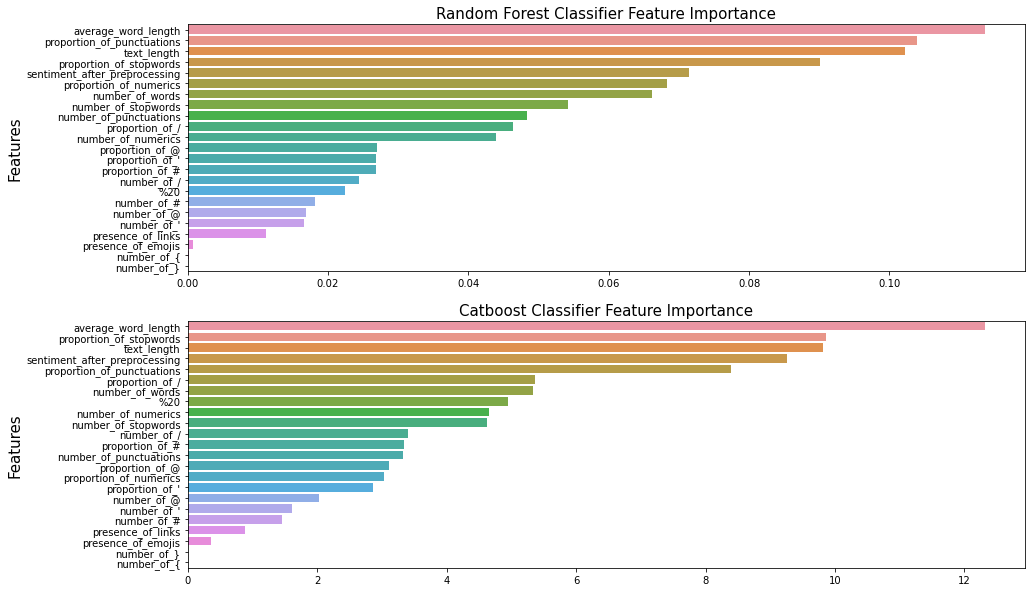

In [73]:
f, axes = plt.subplots(2,1 , figsize=(15, 10))
for i,classifier in enumerate(tuple(model_names.items())):
    indices=np.argsort(classifier[1].feature_importances_)[::-1]
    g=sb.barplot(y=X.columns[indices],x=classifier[1].feature_importances_[indices],ax=axes[i])
    g.set_ylabel('Features',fontsize=15)
    g.tick_params(labelsize=10)
    g.set_title(classifier[0]+' Feature Importance',fontsize=15)

- Observation:
    - top 5 engineered features are:
        0. average_word_length
        1. proportion of punctuations
        2. text length
        3. proportion of stopwords
        4. sentiment after preprocessing


- interestingly, sentiment is actually a good predictor even though its hard to tell in the plots
    - same goes for proportion of numerics
- in both models, number of  { and } are non-predictors so i will not use them
- finally, very interestingly, **'proportion' features tend to be more important than their originals**
    - **features that are combination of two variables like averages and proportions seem to be better predictors**

In [74]:
# drop non predictive variables
to_keep.remove('number_of_{')
to_keep.remove('number_of_}')

## preprocessing of Text variable

### lemmatization


In [75]:
# apply lemmatization
lemmatizer = WordNetLemmatizer() 
disaster_data['text_lemmatized']=disaster_data.text.apply(lambda x: [lemmatizer.lemmatize(word) for word in x.split()])

## visualising word frquencies with word clouds

In [76]:
# preparing text to ve visualised on word cloud
def prepare_text(feature,response_class):
    subset_df=disaster_data.loc[disaster_data.target==response_class,feature]
    text= ' '.join(subset_df.apply(lambda x: ' '.join(x)))
    return text
real_lemmatized_text=prepare_text('text_lemmatized',1)
fake_lemmatized_text=prepare_text('text_lemmatized',0)

Text(0.5, 1.0, 'Fake disaster\nLemmatized text')

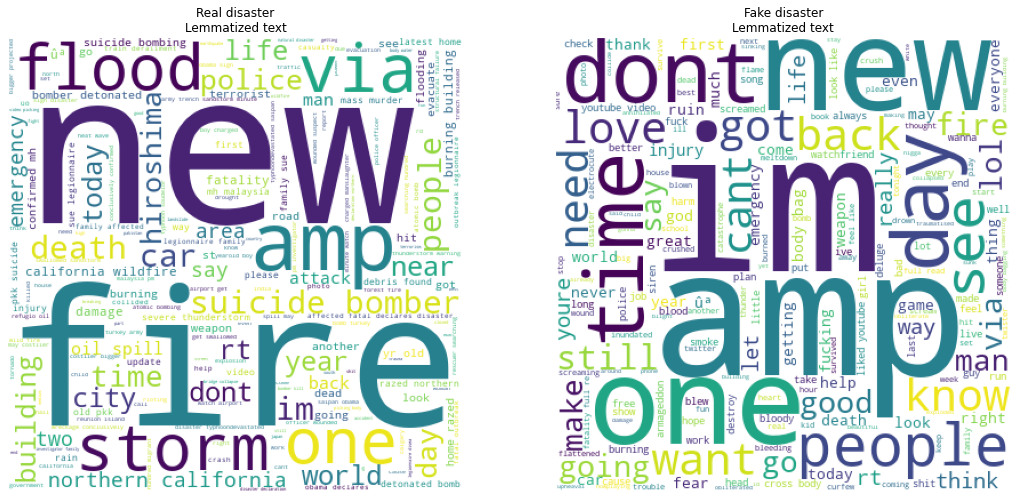

In [77]:
fig, axes = plt.subplots(1, 2, figsize=(18, 10))

ax = axes[0]
wc = WordCloud(background_color="white", max_words=200, width=400, height=400, random_state=1).generate(real_lemmatized_text)
ax.imshow(wc)
ax.axis('off')
ax.set_title('Real disaster\nLemmatized text')

ax = axes[1]
wc = WordCloud(background_color="white", max_words=200, width=400, height=400, random_state=1).generate(fake_lemmatized_text)
ax.imshow(wc)
ax.axis('off')
ax.set_title('Fake disaster\nLemmatized text')

- Observation:
    - some words appear in both real and fake disasters, but they vary in frequency
        - e.g. new and amp
    - **certain words are quite clear cut** to be a certain response class
        - 'fire' is very liekly to be real
        - 'im' is very liekly to be fake

## Leave one out encoding
- since keyword variable has high cardinality and i want to minimise response leakage, i will use leave one out encoding
- it very similar to target encoding but **excludes the current row’s target** when calculating the mean target for a level

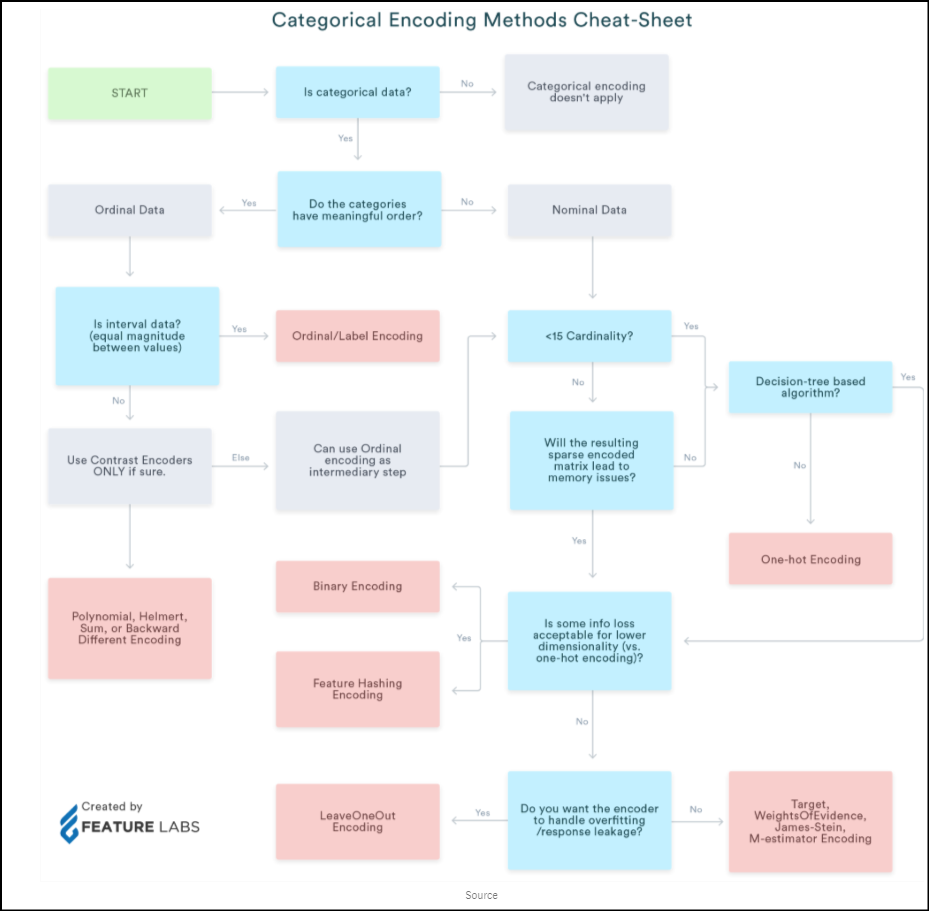

In [4]:
Image('encoding_cheat_sheet.png')

In [ ]:
# fit the encoder
encoder=LeaveOneOutEncoder(cols=['original_keywords'])
encoder.fit(disaster_data,disaster_data.target)

# create the encoded column
disaster_data['keywords_LOO_encoded']=encoder.transform(disaster_data).original_keywords

### regularization dropped
- did not perform as well as desired

In [ ]:
# #encode training set with leave on out and regularize with f fold CV

# #initiate empty encoded column
# disaster_data['keywords_LOO_encoded']=np.nan

# #extract the encoding column and target column
# X=disaster_data.loc[~disaster_data.target.isna(),:]
# y=disaster_data.loc[~disaster_data.target.isna(),'target']

# #apply strtified cross validation
# skf=StratifiedKFold(n_splits=4, random_state=0, shuffle=False)

# for train_index, test_index in skf.split(X, y):
    
#     # folds used for encoding
#     encoding_folds_X=X.iloc[train_index]
#     encoding_folds_y=y.iloc[train_index]
    
#     # train the encoder 
#     encoder=LeaveOneOutEncoder(cols=['original_keywords'])
#     encoder.fit(encoding_folds_X,encoding_folds_y)
    
#     # tranform the target fold 
#     disaster_data.loc[test_index,'keywords_LOO_encoded']=encoder.transform(disaster_data.loc[test_index,:]).original_keywords

In [ ]:
# #encoding of test set is separate, and it is based on the mean of the encoding done in the training set
# test_set_encoder=disaster_data.groupby(['original_keywords']).agg('mean')['keywords_LOO_encoded']
# disaster_data.loc[disaster_data.target.isna(),'keywords_LOO_encoded']=disaster_data.loc[disaster_data.target.isna(),'original_keywords'].map(test_set_encoder)

### apply tfdifvectorizer

- i will use only lemmatized text for my model

In [79]:
# prepare corpus
disaster_data['corpus']=disaster_data.text_lemmatized.apply(lambda x: ' '.join(x))

print('The corpus:')
disaster_data.corpus[:5]

The corpus:


0           deed reason earthquake may allah forgive u
1                forest fire near la ronge sask canada
2    resident asked shelter place notified officer ...
3    people receive wildfire evacuation order calif...
4    got sent photo ruby alaska smoke wildfire pour...
Name: corpus, dtype: object

In [80]:
def n_gram_tfdif_vectorizer(corpus,n_gram,max_features):
    
    # initiate TfidfVectorizer
    vectorizer = TfidfVectorizer(ngram_range=(n_gram,n_gram),max_features=max_features)
    
    # tranform and convert to data frame
    X = vectorizer.fit_transform(corpus)
    feature_names = vectorizer.get_feature_names()
    X = X.todense()
    X = X.tolist()
    n_gram_df = pd.DataFrame(X, columns=feature_names)
    
    return n_gram_df

## Finding the optimal unigrams and bigrams combination

In [81]:
# list of combinations
tuple_list=[(500-n*50,0+n*50) for n in range(1,10)]

In [82]:
n_grams_results=pd.DataFrame(pd.Series(tuple_list),columns=['n_grams_combination'])
n_grams_results['n_grams_combination']=n_grams_results['n_grams_combination'].astype('category')
n_grams_results['cv_score']=np.nan
n_grams_results['cv_std']=np.nan

In [83]:
# initaite model
cbc=CatBoostClassifier(iterations=1000,
                       random_state=0)
# create stratified kfolds
skf = StratifiedKFold(n_splits=4, random_state=1)

In [84]:
# for i,combination in enumerate(tuple_list):
    
#     # apply tfdif vectorizor
#     uni_grams=n_gram_tfdif_vectorizer(disaster_data.corpus,1,combination[0])
#     bi_grams=n_gram_tfdif_vectorizer(disaster_data.corpus,2,combination[1])
    
#     # split into predictors and target variable
#     input_features=pd.concat([uni_grams,bi_grams,disaster_data.target],axis=1)
#     input_features=input_features[~input_features.target.isna()]
#     y = input_features.target
#     X = input_features.drop(['target'],axis=1)
    
#     # apply cross validation
#     accuracy_list = cross_val_score(cbc, X, y, scoring='accuracy', cv=skf, n_jobs=-1)
    
#     # update data frame of results
#     n_grams_results.loc[i,'cv_score']=mean(accuracy_list)
#     n_grams_results.loc[i,'cv_std']=np.std(accuracy_list)
    
    

In [85]:
# f, axes = plt.subplots(1, 1, figsize=(12, 6))
# sb.barplot(y=n_grams_results['n_grams_combination'],x=n_grams_results['cv_score'])
# axes.set_xlim(0.62,)

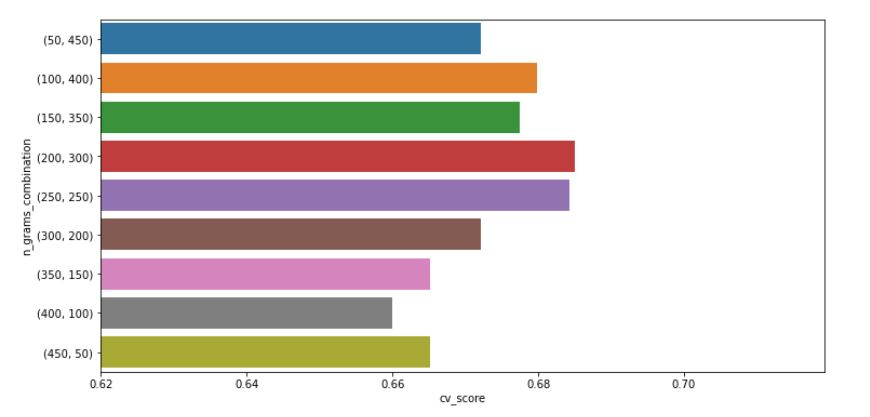

In [7]:
Image('n_grams_combinations.JPG')

- Observation:
    - the optimal unigrams and bigrams combination for this corpus around **200 unigrams, 300 bigrams**

In [86]:
# extracting 200 unigrams and 300 bigrams feature
uni_grams=n_gram_tfdif_vectorizer(disaster_data.corpus,1,200)
bi_grams=n_gram_tfdif_vectorizer(disaster_data.corpus,2,300)

## compiling input features
- i will include id columns since  it was found earlier that it was a relevant predictor

In [87]:
input_features=['id','keywords_LOO_encoded','target']+to_keep+cat_engineered_var
input_df=pd.concat([disaster_data[input_features],uni_grams,bi_grams],axis=1)
print("All input features (and ngrams):\n",input_features)

All input features (and ngrams):
 ['id', 'keywords_LOO_encoded', 'target', 'sentiment_after_preprocessing', 'number_of_words', 'number_of_stopwords', 'proportion_of_stopwords', 'text_length', 'number_of_punctuations', 'proportion_of_punctuations', 'number_of_#', "number_of_'", 'number_of_@', 'number_of_/', 'number_of_numerics', 'proportion_of_#', "proportion_of_'", 'proportion_of_@', 'proportion_of_/', 'proportion_of_numerics', 'average_word_length', 'presence_of_links', 'presence_of_emojis', '%20']


### split to training and test sets

In [88]:
test_set=input_df[input_df.target.isna()]
training_set=input_df[~input_df.target.isna()]

In [89]:
# drop target variable in test set (all NAs)
test_set.drop(['target'],inplace=True,axis=1)

# separate predictors from target variable
y=training_set.target.astype('int64').astype('category')
X=training_set.drop(['target'],axis=1).copy()

# finding the optimal max_depth 
- it takes too long to use hyperparameter tuning, so i will use greedy approach to find the optimal max_depth and number of trees

In [90]:
# max_depth_df=pd.DataFrame({'max_depth_choices':[4,7,10,13],
#                            'scores':np.nan})

In [91]:
# for i,depth in enumerate(max_depth_df.max_depth_choices):
    
#     # initiate model
#     cbc=CatBoostClassifier(iterations=1000,
#                            cat_features=cat_engineered_var,
#                            random_state=0,
#                            # reduce information from golden feature (keywords_LOO_encoded)
#                            per_float_feature_quantization='1:border_count=1024',
#                            max_depth=depth)
    
#     # splitting
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)
    
#     # training model 
#     cbc.fit(X_train,y_train)
    
#     # make prediction on test set
#     y_pred=cbc.predict(X_test)
    
#     # UPDATE SCORES
#     max_depth_df.loc[i,'scores']=accuracy_score(y_test, y_pred)

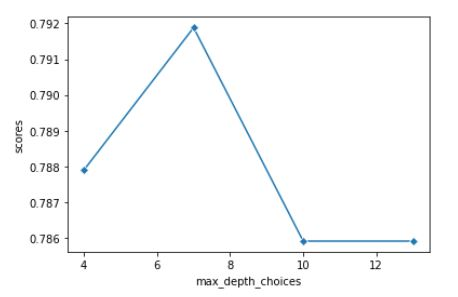

In [5]:
Image('max_depth.JPG')

- Observation: 
    - optimal max_depth is around 7

# train models

In [92]:
# initiate models
rfc=RandomForestClassifier(n_estimators=4000,
                           random_state=0,
                           max_depth=8)
cbc=CatBoostClassifier(iterations=4000,
                       early_stopping_rounds=3000,
                       cat_features=cat_engineered_var,
                       random_state=0,
                       per_float_feature_quantization='1:border_count=1024',
                       max_depth=8)

# train models
rfc.fit(X,y)
cbc.fit(X,y)

Learning rate set to 0.006875
0:	learn: 0.6904560	total: 65.7ms	remaining: 4m 22s
1:	learn: 0.6878547	total: 120ms	remaining: 3m 59s
2:	learn: 0.6853573	total: 174ms	remaining: 3m 51s
3:	learn: 0.6828304	total: 219ms	remaining: 3m 38s
4:	learn: 0.6800969	total: 257ms	remaining: 3m 25s
5:	learn: 0.6777054	total: 300ms	remaining: 3m 19s
6:	learn: 0.6753080	total: 345ms	remaining: 3m 16s
7:	learn: 0.6729227	total: 396ms	remaining: 3m 17s
8:	learn: 0.6705277	total: 433ms	remaining: 3m 11s
9:	learn: 0.6681234	total: 480ms	remaining: 3m 11s
10:	learn: 0.6659667	total: 531ms	remaining: 3m 12s
11:	learn: 0.6636553	total: 578ms	remaining: 3m 12s
12:	learn: 0.6614289	total: 620ms	remaining: 3m 10s
13:	learn: 0.6594458	total: 657ms	remaining: 3m 6s
14:	learn: 0.6573505	total: 700ms	remaining: 3m 6s
15:	learn: 0.6551306	total: 763ms	remaining: 3m 9s
16:	learn: 0.6533724	total: 815ms	remaining: 3m 10s
17:	learn: 0.6509668	total: 860ms	remaining: 3m 10s
18:	learn: 0.6487772	total: 931ms	remaining: 3

159:	learn: 0.5070849	total: 8.1s	remaining: 3m 14s
160:	learn: 0.5067547	total: 8.14s	remaining: 3m 14s
161:	learn: 0.5063367	total: 8.19s	remaining: 3m 14s
162:	learn: 0.5060323	total: 8.25s	remaining: 3m 14s
163:	learn: 0.5056583	total: 8.3s	remaining: 3m 14s
164:	learn: 0.5052332	total: 8.34s	remaining: 3m 13s
165:	learn: 0.5047879	total: 8.39s	remaining: 3m 13s
166:	learn: 0.5043306	total: 8.44s	remaining: 3m 13s
167:	learn: 0.5039584	total: 8.49s	remaining: 3m 13s
168:	learn: 0.5035446	total: 8.54s	remaining: 3m 13s
169:	learn: 0.5031482	total: 8.61s	remaining: 3m 14s
170:	learn: 0.5026733	total: 8.67s	remaining: 3m 14s
171:	learn: 0.5023010	total: 8.72s	remaining: 3m 14s
172:	learn: 0.5018562	total: 8.77s	remaining: 3m 14s
173:	learn: 0.5013332	total: 8.82s	remaining: 3m 14s
174:	learn: 0.5009927	total: 8.88s	remaining: 3m 14s
175:	learn: 0.5004761	total: 8.93s	remaining: 3m 14s
176:	learn: 0.5000939	total: 8.98s	remaining: 3m 13s
177:	learn: 0.4996727	total: 9.03s	remaining: 3m

315:	learn: 0.4666961	total: 16s	remaining: 3m 6s
316:	learn: 0.4665227	total: 16s	remaining: 3m 6s
317:	learn: 0.4663433	total: 16.1s	remaining: 3m 6s
318:	learn: 0.4662305	total: 16.1s	remaining: 3m 6s
319:	learn: 0.4660338	total: 16.2s	remaining: 3m 6s
320:	learn: 0.4658577	total: 16.3s	remaining: 3m 6s
321:	learn: 0.4657114	total: 16.3s	remaining: 3m 6s
322:	learn: 0.4655384	total: 16.4s	remaining: 3m 6s
323:	learn: 0.4654520	total: 16.4s	remaining: 3m 6s
324:	learn: 0.4652827	total: 16.4s	remaining: 3m 6s
325:	learn: 0.4651506	total: 16.5s	remaining: 3m 5s
326:	learn: 0.4649602	total: 16.6s	remaining: 3m 5s
327:	learn: 0.4648082	total: 16.6s	remaining: 3m 5s
328:	learn: 0.4646801	total: 16.6s	remaining: 3m 5s
329:	learn: 0.4645592	total: 16.7s	remaining: 3m 5s
330:	learn: 0.4643822	total: 16.7s	remaining: 3m 5s
331:	learn: 0.4642512	total: 16.8s	remaining: 3m 5s
332:	learn: 0.4641434	total: 16.9s	remaining: 3m 5s
333:	learn: 0.4640208	total: 16.9s	remaining: 3m 5s
334:	learn: 0.46

476:	learn: 0.4476470	total: 24s	remaining: 2m 57s
477:	learn: 0.4475586	total: 24.1s	remaining: 2m 57s
478:	learn: 0.4474672	total: 24.1s	remaining: 2m 57s
479:	learn: 0.4473685	total: 24.1s	remaining: 2m 57s
480:	learn: 0.4472779	total: 24.2s	remaining: 2m 57s
481:	learn: 0.4472062	total: 24.2s	remaining: 2m 56s
482:	learn: 0.4470991	total: 24.3s	remaining: 2m 56s
483:	learn: 0.4470118	total: 24.3s	remaining: 2m 56s
484:	learn: 0.4469352	total: 24.4s	remaining: 2m 56s
485:	learn: 0.4468381	total: 24.4s	remaining: 2m 56s
486:	learn: 0.4467673	total: 24.5s	remaining: 2m 56s
487:	learn: 0.4466631	total: 24.6s	remaining: 2m 56s
488:	learn: 0.4465684	total: 24.6s	remaining: 2m 56s
489:	learn: 0.4464962	total: 24.7s	remaining: 2m 56s
490:	learn: 0.4464261	total: 24.7s	remaining: 2m 56s
491:	learn: 0.4463434	total: 24.8s	remaining: 2m 56s
492:	learn: 0.4462701	total: 24.8s	remaining: 2m 56s
493:	learn: 0.4461674	total: 24.9s	remaining: 2m 56s
494:	learn: 0.4460988	total: 24.9s	remaining: 2m

632:	learn: 0.4357766	total: 31.9s	remaining: 2m 49s
633:	learn: 0.4357035	total: 32s	remaining: 2m 49s
634:	learn: 0.4356332	total: 32s	remaining: 2m 49s
635:	learn: 0.4355661	total: 32.1s	remaining: 2m 49s
636:	learn: 0.4354800	total: 32.1s	remaining: 2m 49s
637:	learn: 0.4354210	total: 32.2s	remaining: 2m 49s
638:	learn: 0.4353542	total: 32.2s	remaining: 2m 49s
639:	learn: 0.4352806	total: 32.3s	remaining: 2m 49s
640:	learn: 0.4352426	total: 32.3s	remaining: 2m 49s
641:	learn: 0.4351770	total: 32.4s	remaining: 2m 49s
642:	learn: 0.4351119	total: 32.4s	remaining: 2m 49s
643:	learn: 0.4350278	total: 32.5s	remaining: 2m 49s
644:	learn: 0.4349844	total: 32.5s	remaining: 2m 49s
645:	learn: 0.4349356	total: 32.6s	remaining: 2m 49s
646:	learn: 0.4348880	total: 32.6s	remaining: 2m 49s
647:	learn: 0.4348026	total: 32.7s	remaining: 2m 49s
648:	learn: 0.4347257	total: 32.7s	remaining: 2m 49s
649:	learn: 0.4346478	total: 32.8s	remaining: 2m 49s
650:	learn: 0.4345569	total: 32.8s	remaining: 2m 4

791:	learn: 0.4258738	total: 39.8s	remaining: 2m 41s
792:	learn: 0.4258212	total: 39.8s	remaining: 2m 41s
793:	learn: 0.4257817	total: 39.9s	remaining: 2m 41s
794:	learn: 0.4257340	total: 39.9s	remaining: 2m 41s
795:	learn: 0.4256925	total: 40s	remaining: 2m 40s
796:	learn: 0.4255989	total: 40s	remaining: 2m 40s
797:	learn: 0.4255534	total: 40.1s	remaining: 2m 40s
798:	learn: 0.4255120	total: 40.1s	remaining: 2m 40s
799:	learn: 0.4254554	total: 40.2s	remaining: 2m 40s
800:	learn: 0.4254142	total: 40.2s	remaining: 2m 40s
801:	learn: 0.4253678	total: 40.3s	remaining: 2m 40s
802:	learn: 0.4253235	total: 40.4s	remaining: 2m 40s
803:	learn: 0.4252700	total: 40.4s	remaining: 2m 40s
804:	learn: 0.4252094	total: 40.4s	remaining: 2m 40s
805:	learn: 0.4251576	total: 40.5s	remaining: 2m 40s
806:	learn: 0.4251136	total: 40.5s	remaining: 2m 40s
807:	learn: 0.4250507	total: 40.6s	remaining: 2m 40s
808:	learn: 0.4249776	total: 40.6s	remaining: 2m 40s
809:	learn: 0.4249253	total: 40.7s	remaining: 2m 4

950:	learn: 0.4173497	total: 47.7s	remaining: 2m 32s
951:	learn: 0.4172928	total: 47.7s	remaining: 2m 32s
952:	learn: 0.4172462	total: 47.8s	remaining: 2m 32s
953:	learn: 0.4171857	total: 47.8s	remaining: 2m 32s
954:	learn: 0.4171416	total: 47.9s	remaining: 2m 32s
955:	learn: 0.4170543	total: 47.9s	remaining: 2m 32s
956:	learn: 0.4170110	total: 48s	remaining: 2m 32s
957:	learn: 0.4169367	total: 48.1s	remaining: 2m 32s
958:	learn: 0.4168934	total: 48.1s	remaining: 2m 32s
959:	learn: 0.4168404	total: 48.2s	remaining: 2m 32s
960:	learn: 0.4168129	total: 48.2s	remaining: 2m 32s
961:	learn: 0.4167715	total: 48.3s	remaining: 2m 32s
962:	learn: 0.4167238	total: 48.3s	remaining: 2m 32s
963:	learn: 0.4166856	total: 48.4s	remaining: 2m 32s
964:	learn: 0.4166402	total: 48.4s	remaining: 2m 32s
965:	learn: 0.4165693	total: 48.5s	remaining: 2m 32s
966:	learn: 0.4165154	total: 48.5s	remaining: 2m 32s
967:	learn: 0.4164795	total: 48.6s	remaining: 2m 32s
968:	learn: 0.4164095	total: 48.6s	remaining: 2m

1105:	learn: 0.4092806	total: 55.5s	remaining: 2m 25s
1106:	learn: 0.4092341	total: 55.5s	remaining: 2m 25s
1107:	learn: 0.4091746	total: 55.6s	remaining: 2m 25s
1108:	learn: 0.4091144	total: 55.7s	remaining: 2m 25s
1109:	learn: 0.4090753	total: 55.7s	remaining: 2m 25s
1110:	learn: 0.4090215	total: 55.7s	remaining: 2m 24s
1111:	learn: 0.4089644	total: 55.8s	remaining: 2m 24s
1112:	learn: 0.4088945	total: 55.9s	remaining: 2m 24s
1113:	learn: 0.4088685	total: 55.9s	remaining: 2m 24s
1114:	learn: 0.4088184	total: 56s	remaining: 2m 24s
1115:	learn: 0.4087716	total: 56s	remaining: 2m 24s
1116:	learn: 0.4087361	total: 56.1s	remaining: 2m 24s
1117:	learn: 0.4086799	total: 56.1s	remaining: 2m 24s
1118:	learn: 0.4086133	total: 56.2s	remaining: 2m 24s
1119:	learn: 0.4085372	total: 56.2s	remaining: 2m 24s
1120:	learn: 0.4085083	total: 56.3s	remaining: 2m 24s
1121:	learn: 0.4084653	total: 56.3s	remaining: 2m 24s
1122:	learn: 0.4084202	total: 56.4s	remaining: 2m 24s
1123:	learn: 0.4083799	total: 56

1260:	learn: 0.4015712	total: 1m 3s	remaining: 2m 17s
1261:	learn: 0.4015365	total: 1m 3s	remaining: 2m 17s
1262:	learn: 0.4014659	total: 1m 3s	remaining: 2m 17s
1263:	learn: 0.4014103	total: 1m 3s	remaining: 2m 17s
1264:	learn: 0.4013470	total: 1m 3s	remaining: 2m 16s
1265:	learn: 0.4012865	total: 1m 3s	remaining: 2m 16s
1266:	learn: 0.4012223	total: 1m 3s	remaining: 2m 16s
1267:	learn: 0.4011663	total: 1m 3s	remaining: 2m 16s
1268:	learn: 0.4011212	total: 1m 3s	remaining: 2m 16s
1269:	learn: 0.4010817	total: 1m 3s	remaining: 2m 16s
1270:	learn: 0.4010302	total: 1m 3s	remaining: 2m 16s
1271:	learn: 0.4009725	total: 1m 3s	remaining: 2m 16s
1272:	learn: 0.4009237	total: 1m 3s	remaining: 2m 16s
1273:	learn: 0.4008729	total: 1m 3s	remaining: 2m 16s
1274:	learn: 0.4008214	total: 1m 3s	remaining: 2m 16s
1275:	learn: 0.4007668	total: 1m 3s	remaining: 2m 16s
1276:	learn: 0.4007048	total: 1m 3s	remaining: 2m 16s
1277:	learn: 0.4006445	total: 1m 4s	remaining: 2m 16s
1278:	learn: 0.4006027	total

1412:	learn: 0.3934002	total: 1m 10s	remaining: 2m 9s
1413:	learn: 0.3933337	total: 1m 10s	remaining: 2m 9s
1414:	learn: 0.3932815	total: 1m 10s	remaining: 2m 9s
1415:	learn: 0.3932196	total: 1m 10s	remaining: 2m 9s
1416:	learn: 0.3931294	total: 1m 10s	remaining: 2m 9s
1417:	learn: 0.3930475	total: 1m 11s	remaining: 2m 9s
1418:	learn: 0.3929742	total: 1m 11s	remaining: 2m 9s
1419:	learn: 0.3929290	total: 1m 11s	remaining: 2m 9s
1420:	learn: 0.3928859	total: 1m 11s	remaining: 2m 9s
1421:	learn: 0.3928364	total: 1m 11s	remaining: 2m 9s
1422:	learn: 0.3927807	total: 1m 11s	remaining: 2m 9s
1423:	learn: 0.3927153	total: 1m 11s	remaining: 2m 9s
1424:	learn: 0.3926567	total: 1m 11s	remaining: 2m 8s
1425:	learn: 0.3926442	total: 1m 11s	remaining: 2m 8s
1426:	learn: 0.3926009	total: 1m 11s	remaining: 2m 8s
1427:	learn: 0.3925398	total: 1m 11s	remaining: 2m 8s
1428:	learn: 0.3924694	total: 1m 11s	remaining: 2m 8s
1429:	learn: 0.3924181	total: 1m 11s	remaining: 2m 8s
1430:	learn: 0.3923549	total

1565:	learn: 0.3846577	total: 1m 18s	remaining: 2m 1s
1566:	learn: 0.3845716	total: 1m 18s	remaining: 2m 1s
1567:	learn: 0.3845104	total: 1m 18s	remaining: 2m 1s
1568:	learn: 0.3844757	total: 1m 18s	remaining: 2m 1s
1569:	learn: 0.3844218	total: 1m 18s	remaining: 2m 1s
1570:	learn: 0.3844132	total: 1m 18s	remaining: 2m 1s
1571:	learn: 0.3843781	total: 1m 18s	remaining: 2m 1s
1572:	learn: 0.3843044	total: 1m 18s	remaining: 2m 1s
1573:	learn: 0.3842528	total: 1m 18s	remaining: 2m 1s
1574:	learn: 0.3842061	total: 1m 18s	remaining: 2m 1s
1575:	learn: 0.3841430	total: 1m 18s	remaining: 2m 1s
1576:	learn: 0.3840882	total: 1m 19s	remaining: 2m 1s
1577:	learn: 0.3840325	total: 1m 19s	remaining: 2m 1s
1578:	learn: 0.3840249	total: 1m 19s	remaining: 2m 1s
1579:	learn: 0.3839774	total: 1m 19s	remaining: 2m 1s
1580:	learn: 0.3839427	total: 1m 19s	remaining: 2m 1s
1581:	learn: 0.3838806	total: 1m 19s	remaining: 2m 1s
1582:	learn: 0.3838654	total: 1m 19s	remaining: 2m 1s
1583:	learn: 0.3837602	total

1717:	learn: 0.3763843	total: 1m 26s	remaining: 1m 54s
1718:	learn: 0.3763053	total: 1m 26s	remaining: 1m 54s
1719:	learn: 0.3762564	total: 1m 26s	remaining: 1m 54s
1720:	learn: 0.3762083	total: 1m 26s	remaining: 1m 54s
1721:	learn: 0.3762015	total: 1m 26s	remaining: 1m 54s
1722:	learn: 0.3761526	total: 1m 26s	remaining: 1m 54s
1723:	learn: 0.3760756	total: 1m 26s	remaining: 1m 54s
1724:	learn: 0.3760121	total: 1m 26s	remaining: 1m 54s
1725:	learn: 0.3759613	total: 1m 26s	remaining: 1m 54s
1726:	learn: 0.3759102	total: 1m 26s	remaining: 1m 53s
1727:	learn: 0.3759042	total: 1m 26s	remaining: 1m 53s
1728:	learn: 0.3758496	total: 1m 26s	remaining: 1m 53s
1729:	learn: 0.3757920	total: 1m 26s	remaining: 1m 53s
1730:	learn: 0.3757316	total: 1m 26s	remaining: 1m 53s
1731:	learn: 0.3757073	total: 1m 26s	remaining: 1m 53s
1732:	learn: 0.3756542	total: 1m 26s	remaining: 1m 53s
1733:	learn: 0.3756466	total: 1m 26s	remaining: 1m 53s
1734:	learn: 0.3755938	total: 1m 26s	remaining: 1m 53s
1735:	lear

1869:	learn: 0.3679492	total: 1m 33s	remaining: 1m 46s
1870:	learn: 0.3679020	total: 1m 33s	remaining: 1m 46s
1871:	learn: 0.3678465	total: 1m 33s	remaining: 1m 46s
1872:	learn: 0.3677777	total: 1m 33s	remaining: 1m 46s
1873:	learn: 0.3677196	total: 1m 33s	remaining: 1m 46s
1874:	learn: 0.3677139	total: 1m 33s	remaining: 1m 46s
1875:	learn: 0.3676604	total: 1m 34s	remaining: 1m 46s
1876:	learn: 0.3675963	total: 1m 34s	remaining: 1m 46s
1877:	learn: 0.3675605	total: 1m 34s	remaining: 1m 46s
1878:	learn: 0.3674911	total: 1m 34s	remaining: 1m 46s
1879:	learn: 0.3674295	total: 1m 34s	remaining: 1m 46s
1880:	learn: 0.3673551	total: 1m 34s	remaining: 1m 46s
1881:	learn: 0.3673055	total: 1m 34s	remaining: 1m 46s
1882:	learn: 0.3672314	total: 1m 34s	remaining: 1m 46s
1883:	learn: 0.3671602	total: 1m 34s	remaining: 1m 46s
1884:	learn: 0.3671050	total: 1m 34s	remaining: 1m 46s
1885:	learn: 0.3670496	total: 1m 34s	remaining: 1m 46s
1886:	learn: 0.3670109	total: 1m 34s	remaining: 1m 45s
1887:	lear

2019:	learn: 0.3599237	total: 1m 41s	remaining: 1m 39s
2020:	learn: 0.3598810	total: 1m 41s	remaining: 1m 39s
2021:	learn: 0.3598421	total: 1m 41s	remaining: 1m 39s
2022:	learn: 0.3597870	total: 1m 41s	remaining: 1m 39s
2023:	learn: 0.3597162	total: 1m 41s	remaining: 1m 39s
2024:	learn: 0.3596985	total: 1m 41s	remaining: 1m 38s
2025:	learn: 0.3596918	total: 1m 41s	remaining: 1m 38s
2026:	learn: 0.3596240	total: 1m 41s	remaining: 1m 38s
2027:	learn: 0.3595979	total: 1m 41s	remaining: 1m 38s
2028:	learn: 0.3595480	total: 1m 41s	remaining: 1m 38s
2029:	learn: 0.3595411	total: 1m 41s	remaining: 1m 38s
2030:	learn: 0.3594855	total: 1m 41s	remaining: 1m 38s
2031:	learn: 0.3594248	total: 1m 41s	remaining: 1m 38s
2032:	learn: 0.3593768	total: 1m 41s	remaining: 1m 38s
2033:	learn: 0.3592992	total: 1m 41s	remaining: 1m 38s
2034:	learn: 0.3592253	total: 1m 42s	remaining: 1m 38s
2035:	learn: 0.3591735	total: 1m 42s	remaining: 1m 38s
2036:	learn: 0.3591199	total: 1m 42s	remaining: 1m 38s
2037:	lear

2169:	learn: 0.3525109	total: 1m 48s	remaining: 1m 31s
2170:	learn: 0.3524683	total: 1m 48s	remaining: 1m 31s
2171:	learn: 0.3524115	total: 1m 48s	remaining: 1m 31s
2172:	learn: 0.3523885	total: 1m 48s	remaining: 1m 31s
2173:	learn: 0.3523450	total: 1m 48s	remaining: 1m 31s
2174:	learn: 0.3522780	total: 1m 48s	remaining: 1m 31s
2175:	learn: 0.3522089	total: 1m 49s	remaining: 1m 31s
2176:	learn: 0.3521435	total: 1m 49s	remaining: 1m 31s
2177:	learn: 0.3520677	total: 1m 49s	remaining: 1m 31s
2178:	learn: 0.3520438	total: 1m 49s	remaining: 1m 31s
2179:	learn: 0.3520182	total: 1m 49s	remaining: 1m 31s
2180:	learn: 0.3519910	total: 1m 49s	remaining: 1m 31s
2181:	learn: 0.3519349	total: 1m 49s	remaining: 1m 31s
2182:	learn: 0.3519287	total: 1m 49s	remaining: 1m 31s
2183:	learn: 0.3519226	total: 1m 49s	remaining: 1m 31s
2184:	learn: 0.3518596	total: 1m 49s	remaining: 1m 30s
2185:	learn: 0.3518096	total: 1m 49s	remaining: 1m 30s
2186:	learn: 0.3517487	total: 1m 49s	remaining: 1m 30s
2187:	lear

2321:	learn: 0.3454792	total: 1m 56s	remaining: 1m 24s
2322:	learn: 0.3453997	total: 1m 56s	remaining: 1m 24s
2323:	learn: 0.3453588	total: 1m 56s	remaining: 1m 23s
2324:	learn: 0.3453142	total: 1m 56s	remaining: 1m 23s
2325:	learn: 0.3452665	total: 1m 56s	remaining: 1m 23s
2326:	learn: 0.3451959	total: 1m 56s	remaining: 1m 23s
2327:	learn: 0.3451311	total: 1m 56s	remaining: 1m 23s
2328:	learn: 0.3450922	total: 1m 56s	remaining: 1m 23s
2329:	learn: 0.3450613	total: 1m 56s	remaining: 1m 23s
2330:	learn: 0.3449746	total: 1m 56s	remaining: 1m 23s
2331:	learn: 0.3449202	total: 1m 56s	remaining: 1m 23s
2332:	learn: 0.3448645	total: 1m 56s	remaining: 1m 23s
2333:	learn: 0.3448081	total: 1m 56s	remaining: 1m 23s
2334:	learn: 0.3447409	total: 1m 57s	remaining: 1m 23s
2335:	learn: 0.3447177	total: 1m 57s	remaining: 1m 23s
2336:	learn: 0.3446441	total: 1m 57s	remaining: 1m 23s
2337:	learn: 0.3445928	total: 1m 57s	remaining: 1m 23s
2338:	learn: 0.3445384	total: 1m 57s	remaining: 1m 23s
2339:	lear

2473:	learn: 0.3384163	total: 2m 3s	remaining: 1m 16s
2474:	learn: 0.3383805	total: 2m 3s	remaining: 1m 16s
2475:	learn: 0.3383272	total: 2m 4s	remaining: 1m 16s
2476:	learn: 0.3382652	total: 2m 4s	remaining: 1m 16s
2477:	learn: 0.3382053	total: 2m 4s	remaining: 1m 16s
2478:	learn: 0.3381473	total: 2m 4s	remaining: 1m 16s
2479:	learn: 0.3380890	total: 2m 4s	remaining: 1m 16s
2480:	learn: 0.3380181	total: 2m 4s	remaining: 1m 16s
2481:	learn: 0.3379924	total: 2m 4s	remaining: 1m 16s
2482:	learn: 0.3379594	total: 2m 4s	remaining: 1m 15s
2483:	learn: 0.3379138	total: 2m 4s	remaining: 1m 15s
2484:	learn: 0.3378645	total: 2m 4s	remaining: 1m 15s
2485:	learn: 0.3377893	total: 2m 4s	remaining: 1m 15s
2486:	learn: 0.3377388	total: 2m 4s	remaining: 1m 15s
2487:	learn: 0.3376976	total: 2m 4s	remaining: 1m 15s
2488:	learn: 0.3376544	total: 2m 4s	remaining: 1m 15s
2489:	learn: 0.3376411	total: 2m 4s	remaining: 1m 15s
2490:	learn: 0.3375760	total: 2m 4s	remaining: 1m 15s
2491:	learn: 0.3375239	total

2627:	learn: 0.3316417	total: 2m 11s	remaining: 1m 8s
2628:	learn: 0.3315865	total: 2m 11s	remaining: 1m 8s
2629:	learn: 0.3315443	total: 2m 11s	remaining: 1m 8s
2630:	learn: 0.3314873	total: 2m 11s	remaining: 1m 8s
2631:	learn: 0.3314267	total: 2m 11s	remaining: 1m 8s
2632:	learn: 0.3313626	total: 2m 11s	remaining: 1m 8s
2633:	learn: 0.3313085	total: 2m 11s	remaining: 1m 8s
2634:	learn: 0.3312639	total: 2m 11s	remaining: 1m 8s
2635:	learn: 0.3312164	total: 2m 11s	remaining: 1m 8s
2636:	learn: 0.3311665	total: 2m 12s	remaining: 1m 8s
2637:	learn: 0.3311621	total: 2m 12s	remaining: 1m 8s
2638:	learn: 0.3311179	total: 2m 12s	remaining: 1m 8s
2639:	learn: 0.3310650	total: 2m 12s	remaining: 1m 8s
2640:	learn: 0.3310523	total: 2m 12s	remaining: 1m 8s
2641:	learn: 0.3310074	total: 2m 12s	remaining: 1m 8s
2642:	learn: 0.3309797	total: 2m 12s	remaining: 1m 7s
2643:	learn: 0.3309190	total: 2m 12s	remaining: 1m 7s
2644:	learn: 0.3308736	total: 2m 12s	remaining: 1m 7s
2645:	learn: 0.3308197	total

2779:	learn: 0.3253381	total: 2m 19s	remaining: 1m 1s
2780:	learn: 0.3252745	total: 2m 20s	remaining: 1m 1s
2781:	learn: 0.3252654	total: 2m 20s	remaining: 1m 1s
2782:	learn: 0.3252332	total: 2m 20s	remaining: 1m 1s
2783:	learn: 0.3251948	total: 2m 20s	remaining: 1m 1s
2784:	learn: 0.3251386	total: 2m 20s	remaining: 1m 1s
2785:	learn: 0.3251044	total: 2m 20s	remaining: 1m 1s
2786:	learn: 0.3250741	total: 2m 20s	remaining: 1m 1s
2787:	learn: 0.3250235	total: 2m 20s	remaining: 1m 1s
2788:	learn: 0.3249756	total: 2m 20s	remaining: 1m 1s
2789:	learn: 0.3249207	total: 2m 20s	remaining: 1m
2790:	learn: 0.3248895	total: 2m 20s	remaining: 1m
2791:	learn: 0.3248460	total: 2m 20s	remaining: 1m
2792:	learn: 0.3247918	total: 2m 20s	remaining: 1m
2793:	learn: 0.3247497	total: 2m 20s	remaining: 1m
2794:	learn: 0.3246868	total: 2m 20s	remaining: 1m
2795:	learn: 0.3246695	total: 2m 20s	remaining: 1m
2796:	learn: 0.3246031	total: 2m 21s	remaining: 1m
2797:	learn: 0.3245610	total: 2m 21s	remaining: 1m
2

2934:	learn: 0.3188129	total: 2m 29s	remaining: 54.3s
2935:	learn: 0.3187596	total: 2m 29s	remaining: 54.3s
2936:	learn: 0.3187156	total: 2m 29s	remaining: 54.2s
2937:	learn: 0.3186752	total: 2m 29s	remaining: 54.2s
2938:	learn: 0.3186320	total: 2m 29s	remaining: 54.1s
2939:	learn: 0.3185836	total: 2m 29s	remaining: 54.1s
2940:	learn: 0.3185286	total: 2m 30s	remaining: 54s
2941:	learn: 0.3184801	total: 2m 30s	remaining: 54s
2942:	learn: 0.3184363	total: 2m 30s	remaining: 53.9s
2943:	learn: 0.3183896	total: 2m 30s	remaining: 53.9s
2944:	learn: 0.3183339	total: 2m 30s	remaining: 53.8s
2945:	learn: 0.3183044	total: 2m 30s	remaining: 53.8s
2946:	learn: 0.3182697	total: 2m 30s	remaining: 53.7s
2947:	learn: 0.3182009	total: 2m 30s	remaining: 53.7s
2948:	learn: 0.3181640	total: 2m 30s	remaining: 53.6s
2949:	learn: 0.3181195	total: 2m 30s	remaining: 53.6s
2950:	learn: 0.3180556	total: 2m 30s	remaining: 53.5s
2951:	learn: 0.3180176	total: 2m 30s	remaining: 53.5s
2952:	learn: 0.3179730	total: 2m

3090:	learn: 0.3125093	total: 2m 38s	remaining: 46.7s
3091:	learn: 0.3124825	total: 2m 38s	remaining: 46.6s
3092:	learn: 0.3124578	total: 2m 38s	remaining: 46.6s
3093:	learn: 0.3124036	total: 2m 38s	remaining: 46.5s
3094:	learn: 0.3123833	total: 2m 38s	remaining: 46.5s
3095:	learn: 0.3123419	total: 2m 38s	remaining: 46.4s
3096:	learn: 0.3122886	total: 2m 38s	remaining: 46.3s
3097:	learn: 0.3122494	total: 2m 39s	remaining: 46.3s
3098:	learn: 0.3122166	total: 2m 39s	remaining: 46.3s
3099:	learn: 0.3121748	total: 2m 39s	remaining: 46.2s
3100:	learn: 0.3121319	total: 2m 39s	remaining: 46.2s
3101:	learn: 0.3120823	total: 2m 39s	remaining: 46.1s
3102:	learn: 0.3120782	total: 2m 39s	remaining: 46s
3103:	learn: 0.3120204	total: 2m 39s	remaining: 46s
3104:	learn: 0.3119810	total: 2m 39s	remaining: 45.9s
3105:	learn: 0.3119155	total: 2m 39s	remaining: 45.9s
3106:	learn: 0.3118666	total: 2m 39s	remaining: 45.8s
3107:	learn: 0.3118348	total: 2m 39s	remaining: 45.8s
3108:	learn: 0.3118114	total: 2m

3244:	learn: 0.3065339	total: 2m 47s	remaining: 38.9s
3245:	learn: 0.3064859	total: 2m 47s	remaining: 38.8s
3246:	learn: 0.3064571	total: 2m 47s	remaining: 38.8s
3247:	learn: 0.3064138	total: 2m 47s	remaining: 38.7s
3248:	learn: 0.3063962	total: 2m 47s	remaining: 38.7s
3249:	learn: 0.3063925	total: 2m 47s	remaining: 38.6s
3250:	learn: 0.3063469	total: 2m 47s	remaining: 38.6s
3251:	learn: 0.3063071	total: 2m 47s	remaining: 38.5s
3252:	learn: 0.3062845	total: 2m 47s	remaining: 38.5s
3253:	learn: 0.3062266	total: 2m 47s	remaining: 38.4s
3254:	learn: 0.3061918	total: 2m 47s	remaining: 38.4s
3255:	learn: 0.3061354	total: 2m 47s	remaining: 38.3s
3256:	learn: 0.3061078	total: 2m 47s	remaining: 38.3s
3257:	learn: 0.3060687	total: 2m 47s	remaining: 38.2s
3258:	learn: 0.3060240	total: 2m 47s	remaining: 38.2s
3259:	learn: 0.3059785	total: 2m 47s	remaining: 38.1s
3260:	learn: 0.3059219	total: 2m 47s	remaining: 38.1s
3261:	learn: 0.3059164	total: 2m 47s	remaining: 38s
3262:	learn: 0.3059128	total: 

3399:	learn: 0.3012576	total: 2m 55s	remaining: 30.9s
3400:	learn: 0.3012216	total: 2m 55s	remaining: 30.9s
3401:	learn: 0.3011853	total: 2m 55s	remaining: 30.8s
3402:	learn: 0.3011330	total: 2m 55s	remaining: 30.8s
3403:	learn: 0.3010907	total: 2m 55s	remaining: 30.7s
3404:	learn: 0.3010672	total: 2m 55s	remaining: 30.7s
3405:	learn: 0.3010490	total: 2m 55s	remaining: 30.6s
3406:	learn: 0.3010139	total: 2m 55s	remaining: 30.6s
3407:	learn: 0.3009573	total: 2m 55s	remaining: 30.5s
3408:	learn: 0.3009205	total: 2m 55s	remaining: 30.5s
3409:	learn: 0.3008796	total: 2m 55s	remaining: 30.4s
3410:	learn: 0.3008353	total: 2m 55s	remaining: 30.4s
3411:	learn: 0.3008290	total: 2m 55s	remaining: 30.3s
3412:	learn: 0.3008025	total: 2m 56s	remaining: 30.3s
3413:	learn: 0.3007514	total: 2m 56s	remaining: 30.2s
3414:	learn: 0.3007182	total: 2m 56s	remaining: 30.2s
3415:	learn: 0.3006809	total: 2m 56s	remaining: 30.1s
3416:	learn: 0.3006407	total: 2m 56s	remaining: 30.1s
3417:	learn: 0.3006016	total

3554:	learn: 0.2959110	total: 3m 5s	remaining: 23.2s
3555:	learn: 0.2958942	total: 3m 5s	remaining: 23.2s
3556:	learn: 0.2958476	total: 3m 5s	remaining: 23.1s
3557:	learn: 0.2958031	total: 3m 5s	remaining: 23.1s
3558:	learn: 0.2957417	total: 3m 5s	remaining: 23s
3559:	learn: 0.2956893	total: 3m 5s	remaining: 23s
3560:	learn: 0.2956458	total: 3m 5s	remaining: 22.9s
3561:	learn: 0.2956166	total: 3m 5s	remaining: 22.9s
3562:	learn: 0.2955919	total: 3m 6s	remaining: 22.8s
3563:	learn: 0.2955517	total: 3m 6s	remaining: 22.8s
3564:	learn: 0.2955230	total: 3m 6s	remaining: 22.7s
3565:	learn: 0.2954818	total: 3m 6s	remaining: 22.7s
3566:	learn: 0.2954412	total: 3m 6s	remaining: 22.6s
3567:	learn: 0.2954120	total: 3m 6s	remaining: 22.6s
3568:	learn: 0.2953605	total: 3m 6s	remaining: 22.5s
3569:	learn: 0.2953187	total: 3m 6s	remaining: 22.5s
3570:	learn: 0.2952767	total: 3m 6s	remaining: 22.4s
3571:	learn: 0.2952361	total: 3m 6s	remaining: 22.4s
3572:	learn: 0.2952035	total: 3m 6s	remaining: 22.

3711:	learn: 0.2902261	total: 3m 15s	remaining: 15.1s
3712:	learn: 0.2901883	total: 3m 15s	remaining: 15.1s
3713:	learn: 0.2901567	total: 3m 15s	remaining: 15s
3714:	learn: 0.2901115	total: 3m 15s	remaining: 15s
3715:	learn: 0.2900771	total: 3m 15s	remaining: 14.9s
3716:	learn: 0.2900476	total: 3m 15s	remaining: 14.9s
3717:	learn: 0.2900223	total: 3m 15s	remaining: 14.8s
3718:	learn: 0.2899771	total: 3m 15s	remaining: 14.8s
3719:	learn: 0.2899163	total: 3m 15s	remaining: 14.7s
3720:	learn: 0.2898792	total: 3m 15s	remaining: 14.7s
3721:	learn: 0.2898301	total: 3m 15s	remaining: 14.6s
3722:	learn: 0.2897821	total: 3m 15s	remaining: 14.6s
3723:	learn: 0.2897610	total: 3m 15s	remaining: 14.5s
3724:	learn: 0.2897256	total: 3m 15s	remaining: 14.5s
3725:	learn: 0.2896820	total: 3m 15s	remaining: 14.4s
3726:	learn: 0.2896318	total: 3m 16s	remaining: 14.4s
3727:	learn: 0.2896029	total: 3m 16s	remaining: 14.3s
3728:	learn: 0.2895690	total: 3m 16s	remaining: 14.3s
3729:	learn: 0.2895310	total: 3m

3866:	learn: 0.2848694	total: 3m 26s	remaining: 7.09s
3867:	learn: 0.2848173	total: 3m 26s	remaining: 7.04s
3868:	learn: 0.2847745	total: 3m 26s	remaining: 6.98s
3869:	learn: 0.2847490	total: 3m 26s	remaining: 6.93s
3870:	learn: 0.2847118	total: 3m 26s	remaining: 6.88s
3871:	learn: 0.2846747	total: 3m 26s	remaining: 6.82s
3872:	learn: 0.2846536	total: 3m 26s	remaining: 6.77s
3873:	learn: 0.2846205	total: 3m 26s	remaining: 6.72s
3874:	learn: 0.2845940	total: 3m 26s	remaining: 6.66s
3875:	learn: 0.2845302	total: 3m 26s	remaining: 6.61s
3876:	learn: 0.2844993	total: 3m 26s	remaining: 6.56s
3877:	learn: 0.2844793	total: 3m 26s	remaining: 6.5s
3878:	learn: 0.2844368	total: 3m 26s	remaining: 6.45s
3879:	learn: 0.2843907	total: 3m 26s	remaining: 6.4s
3880:	learn: 0.2843554	total: 3m 26s	remaining: 6.34s
3881:	learn: 0.2843244	total: 3m 26s	remaining: 6.29s
3882:	learn: 0.2842917	total: 3m 27s	remaining: 6.24s
3883:	learn: 0.2842550	total: 3m 27s	remaining: 6.18s
3884:	learn: 0.2842327	total: 

In [93]:
# predict 
rfc_predictions=rfc.predict(test_set)
cbc_predictions=cbc.predict(test_set)

# compiling results
rfc_results=pd.concat([test_data[['id']],pd.Series(rfc_predictions,name='target')],axis=1)
cbc_results=pd.concat([test_data[['id']],pd.Series(cbc_predictions,name='target')],axis=1)

# export to csv
rfc_results.to_csv('randomForest_predictions.csv',index=False)
cbc_results.to_csv('catBoost_predictions.csv',index=False)

Text(0.5, 1.0, ' Feature Importance')

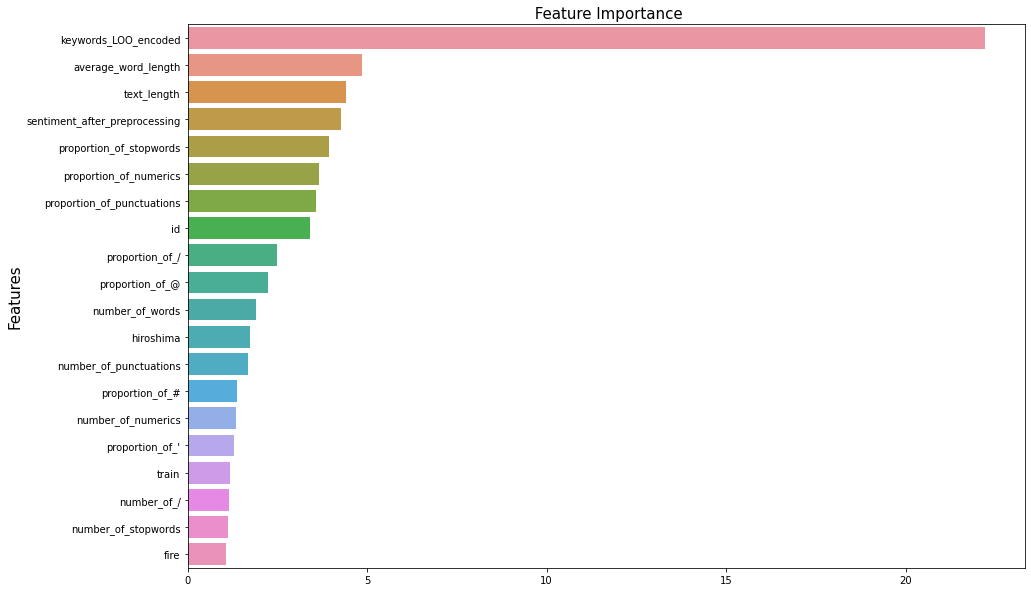

In [94]:
top_n_features=20
f, axes = plt.subplots(1,1 , figsize=(15, 10))
indices=np.argsort(cbc.feature_importances_)[:10:-1]
g=sb.barplot(y=X.columns[indices[:top_n_features]],x=cbc.feature_importances_[indices[:top_n_features]])
g.set_ylabel('Features',fontsize=15)
g.tick_params(labelsize=10)
g.set_title(' Feature Importance',fontsize=15)

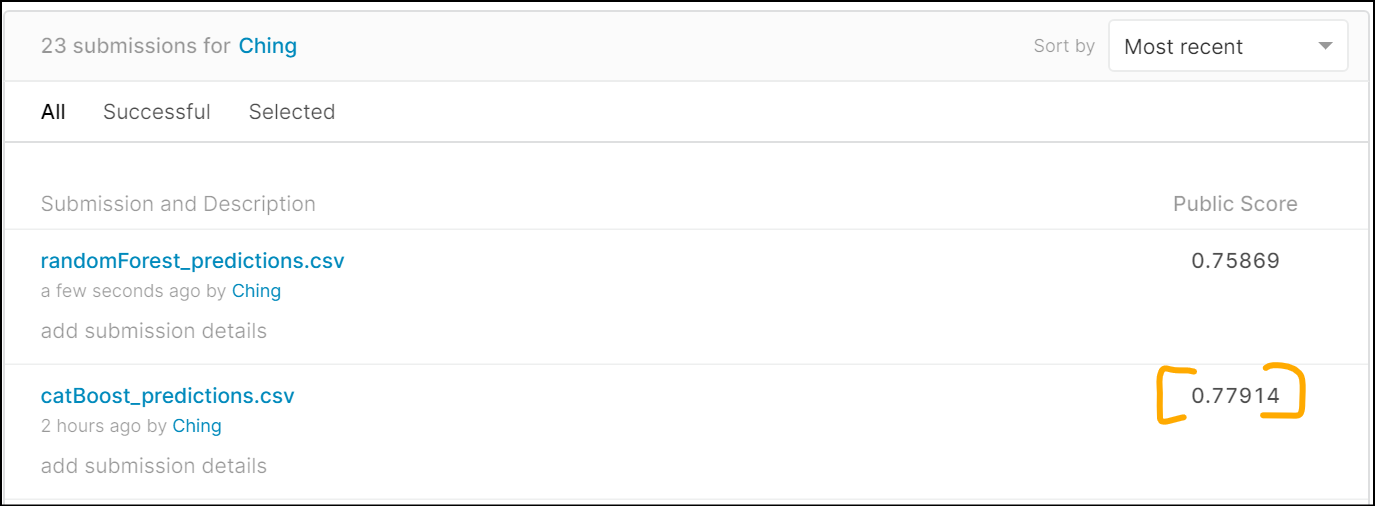

In [6]:
Image('score.png')

- Final thoughts:
    - Mean encoding is a powerful tool to capture information from high cardinality variables like the 'keyword' column
        - however proper regulartization like **leave one out** or Kfold CV is needed to minimise overfitting and target leakage
        - in cases were cardinality is high, one hot encoding is most certainly not appropriate
        - in this case frequency encoding is also not good idea. that emphasizes the **importance of visualising engineered features** first
    - Engineered features that are a **combination of multiple variables tend to perform better**
        - e.g. average word length takes length divided by number of words
        - e.g. proportion of stopwords take number of stopwords divided by number of words
    - **N_grams** most certainly helps improve NLP models because they capture more context
    - it is important to tune the model, otherwise it tends to overfit and perform poorly in the test
        - e.g. **max_depth** limits the number of levels in each tree thereby reducing overfitting and slightly improving performance
    - it's a **good practice not to judge a variable by its name**,
        - 'id' in this case was actually a decent predictor because the rows are grouped by keywords
    
- Possible improvements on this project:
    - the models can be further tuned with **more hyperparameters** like min_samples_split or learning rate
        - however, the **trade off** isn't good either because the computational time to way too much
        
    - n_grams can be further improved with **tri_grams** etc.
    
    - performance can actually tremendously improve by using **BERT**, which a pre-trained NLP model

In [95]:
print("\U0001F923")

🤣
